In [1]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.0 MB/s eta 0:00:00


In [2]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 31.4 MB/s eta 0:00:00


In [3]:
# ==============================
# Diploma Project: Sales Forecasting with Machine Learning
# Focus: Feature Engineering + Hyperparameter Tuning
# ==============================

import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=TqdmWarning)

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [4]:
# ==============================
# Data Loading (20% Sample)
# ==============================
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File paths
train_path = "/content/drive/MyDrive/Data_sets/Rossmann/train.csv"
store_path = "/content/drive/MyDrive/Data_sets/Rossmann/store.csv"

print("Loading data...")
train = pd.read_csv(train_path, low_memory=False)
store = pd.read_csv(store_path, low_memory=False)

# Use only 20% random sample for faster experimentation
train_sample = train.sample(frac=0.2, random_state=42).reset_index(drop=True)

# Merge with store information
df = pd.merge(train_sample, store, on="Store", how="left")

# Report dataset shape
print(f"Using only 20% of data: {df.shape[0]:,} rows, {df.shape[1]} columns")

Mounted at /content/drive
Loading data...
Using only 20% of data: 203,442 rows, 18 columns


In [5]:
# ================================================================
# EDA: Basic Data Analysis
# ================================================================
print("\nGeneral information about the dataset:")
df.info()


General information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203442 entries, 0 to 203441
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      203442 non-null  int64  
 1   DayOfWeek                  203442 non-null  int64  
 2   Date                       203442 non-null  object 
 3   Sales                      203442 non-null  int64  
 4   Customers                  203442 non-null  int64  
 5   Open                       203442 non-null  int64  
 6   Promo                      203442 non-null  int64  
 7   StateHoliday               203442 non-null  object 
 8   SchoolHoliday              203442 non-null  int64  
 9   StoreType                  203442 non-null  object 
 10  Assortment                 203442 non-null  object 
 11  CompetitionDistance        202921 non-null  float64
 12  CompetitionOpenSinceMonth  138703 non-null  fl

In [6]:
print("\nFirst 5 rows of the dataset:")
display(df.head())


First 5 rows of the dataset:


Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0    616          7  2015-05-24      0          0     0      0            0   
1    592          2  2013-03-26   5548        710     1      1            0   
2    526          6  2013-09-14   7467       1150     1      0            0   
3    601          2  2013-07-23   3360        323     1      0            0   
4    953          1  2014-12-15  11414        853     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              0         a          c               3040.0   
1              1         a          a               2540.0   
2              0         a          a                120.0   
3              1         d          a               8220.0   
4              0         a          a              19830.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        8.0                    2011.0       1   
1                        6.0                    2005.0       0   
2                        NaN                       NaN       1   
3                        4.0                    2014.0       1   
4                        4.0                    2006.0       1   

   Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0             35.0           2010.0  Mar,Jun,Sept,Dec  
1              NaN              NaN               NaN  
2             48.0           2011.0  Mar,Jun,Sept,Dec  
3             14.0           2011.0   Jan,Apr,Jul,Oct  
4             22.0           2011.0  Mar,Jun,Sept,Dec

In [7]:
print("\nDescriptive statistics:")
display(df.describe().round(2))


Descriptive statistics:


Store  DayOfWeek      Sales  Customers       Open      Promo  \
count  203442.00   203442.0  203442.00  203442.00  203442.00  203442.00   
mean      558.25        4.0    5770.38     633.06       0.83       0.38   
std       321.81        2.0    3845.63     464.90       0.38       0.49   
min         1.00        1.0       0.00       0.00       0.00       0.00   
25%       280.00        2.0    3732.00     405.00       1.00       0.00   
50%       558.00        4.0    5749.00     610.00       1.00       0.00   
75%       837.00        6.0    7848.00     836.00       1.00       1.00   
max      1115.00        7.0   41551.00    7388.00       1.00       1.00   

       SchoolHoliday  CompetitionDistance  CompetitionOpenSinceMonth  \
count      203442.00            202921.00                  138703.00   
mean            0.18              5449.84                       7.21   
std             0.38              7714.90                       3.22   
min             0.00                20.00                       1.00   
25%             0.00               710.00                       4.00   
50%             0.00              2330.00                       8.00   
75%             0.00              6900.00                      10.00   
max             1.00             75860.00                      12.00   

       CompetitionOpenSinceYear    Promo2  Promo2SinceWeek  Promo2SinceYear  
count                 138703.00  203442.0        101636.00        101636.00  
mean                    2008.72       0.5            23.22          2011.75  
std                        5.97       0.5            14.10             1.66  
min                     1900.00       0.0             1.00          2009.00  
25%                     2006.00       0.0            13.00          2011.00  
50%                     2010.00       0.0            22.00          2012.00  
75%                     2013.00       1.0            37.00          2013.00  
max                     2015.00       1.0            50.00          2015.00

In [8]:
print(f"\nNumber of unique stores (Store): {df['Store'].nunique()}")
print(f"Date range: {df['Date'].min()} — {df['Date'].max()}")
print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")


Number of unique stores (Store): 1115
Date range: 2013-01-01 — 2015-07-31
Dataset size: 203442 rows, 18 columns


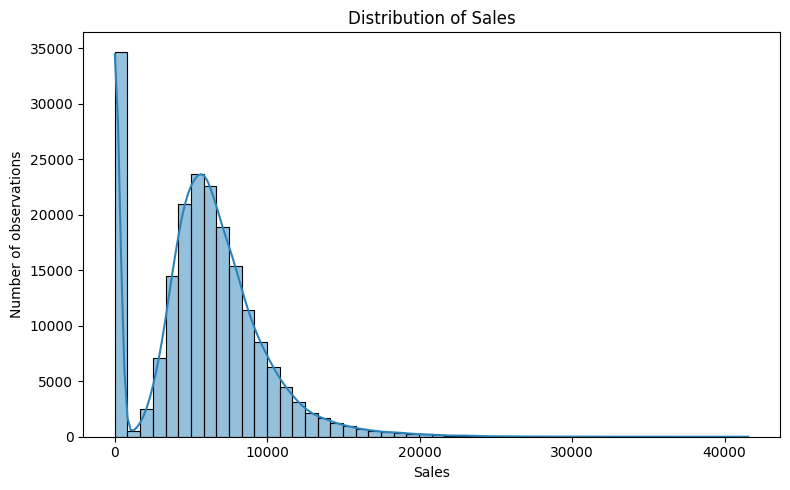

In [9]:
# ------------------------------------------------
# Distribution of the target variable (Sales)
# ------------------------------------------------
plt.figure(figsize=(8, 5))
sns.histplot(df["Sales"], bins=50, kde=True, color="#2b83ba")
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Number of observations")
plt.tight_layout()
plt.show()

In [10]:
# ------------------------------------------------
# Share of days when stores were open
# ------------------------------------------------
open_share = df["Open"].mean() * 100
print(f"Stores were open in {open_share:.1f}% of all records.")

Stores were open in 83.0% of all records.


In [11]:
# Share of days with sales above 20,000
share = len(df[df["Sales"] > 20000]) / len(df) * 100
print(f"Share of high-sales days (>20,000): {share:.2f}%")

Share of high-sales days (>20,000): 0.40%


In [12]:
# ==============================
# Missing Values and Duplicates Check
# ==============================

# Check missing values before cleaning
missing_before = df.isnull().sum()
missing_before = missing_before[missing_before > 0]

if not missing_before.empty:
    print("\nMissing values before cleaning:")
    print(missing_before)
else:
    print("\nNo missing values found before cleaning.")

# Check duplicates
duplicates_before = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates_before}")

# Remove duplicates
df.drop_duplicates(inplace=True)

duplicates_after = df.duplicated().sum()
print(f"Number of duplicates after cleaning: {duplicates_after}")


Missing values before cleaning:
CompetitionDistance             521
CompetitionOpenSinceMonth     64739
CompetitionOpenSinceYear      64739
Promo2SinceWeek              101806
Promo2SinceYear              101806
PromoInterval                101806
dtype: int64

Number of duplicate rows: 0
Number of duplicates after cleaning: 0


In [13]:
# ==============================
# Missing Value Handling
# ==============================
# Fill missing numeric values
df["CompetitionDistance"] = df["CompetitionDistance"].fillna(df["CompetitionDistance"].median())
df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].fillna(0)
df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].fillna(0)
df["Promo2SinceWeek"] = df["Promo2SinceWeek"].fillna(0)
df["Promo2SinceYear"] = df["Promo2SinceYear"].fillna(0)

# Fill missing categorical values
df["PromoInterval"] = df["PromoInterval"].fillna("None")

# Summary of remaining missing values
missing = df.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print("\nRemaining missing values:")
    print(missing)
else:
    print("\nNo missing values remaining.")


No missing values remaining.


In [14]:
# ==============================
# Time Feature Engineering
# ==============================
# Convert to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Extract time-based features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["IsWeekend"] = df["DayOfWeek"].isin([5, 6]).astype(int)

print("Time-based features created:", ["Year", "Month", "Day", "DayOfWeek", "IsWeekend"])

Time-based features created: ['Year', 'Month', 'Day', 'DayOfWeek', 'IsWeekend']


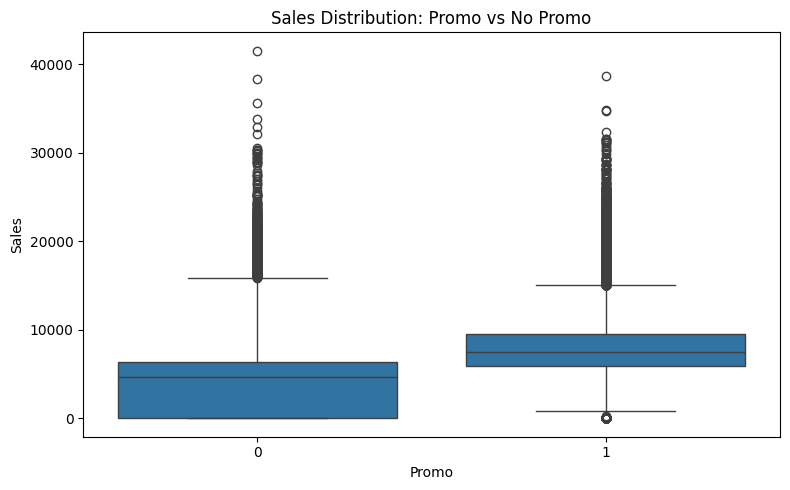


Share of extreme sales values (>20000): 0.40%


In [15]:
# ==============================
# Outlier Analysis
# ==============================
# Visualize sales distribution with and without promotion
plt.figure(figsize=(8, 5))
sns.boxplot(x="Promo", y="Sales", data=df)
plt.title("Sales Distribution: Promo vs No Promo")
plt.tight_layout()
plt.show()

# Detect and quantify extreme sales values
high_sales = df[df["Sales"] > 20000]
share = len(high_sales) / len(df) * 100

print(f"\nShare of extreme sales values (>20000): {share:.2f}%")

In [16]:
# ==============================
# Data Cleaning and Encoding
# ==============================

# Remove days when the store was closed
df = df[df["Open"] == 1].copy()

# Define target and features
target = "Sales"
X = df.drop(columns=[target, "Date", "Customers", "Open"])
y = df[target]

# Ensure all string/object columns are properly typed and filled
for col in X.columns:
    if X[col].dtype == "object" or X[col].apply(lambda v: isinstance(v, str)).any():
        X[col] = X[col].fillna("missing").astype(str)

# Identify categorical columns
cat_columns = X.select_dtypes(include="object").columns.tolist()
print(f"\nCategorical columns to encode: {cat_columns}")

# Label Encoding for categorical features
le = LabelEncoder()
for col in cat_columns:
    X[col] = le.fit_transform(X[col])

print(f"Data shape after encoding: {X.shape}")


Categorical columns to encode: ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
Data shape after encoding: (168798, 18)


 Initial Correlation Matrix (Before Feature Removal):


Store  DayOfWeek     Promo  StateHoliday  \
Store                      1.000000   0.000007 -0.004341      0.005665   
DayOfWeek                  0.000007   1.000000 -0.291773     -0.004659   
Promo                     -0.004341  -0.291773  1.000000     -0.006900   
StateHoliday               0.005665  -0.004659 -0.006900      1.000000   
SchoolHoliday              0.001988  -0.138165  0.029729      0.023351   
StoreType                 -0.022318  -0.004349  0.001714     -0.004057   
Assortment                 0.010595   0.000931  0.001996     -0.000931   
CompetitionDistance       -0.027001   0.002833 -0.003279      0.005491   
CompetitionOpenSinceMonth -0.030882  -0.000707 -0.000492     -0.002944   
CompetitionOpenSinceYear  -0.006006  -0.004162  0.000052     -0.004783   
Promo2                     0.007460  -0.000612 -0.003972     -0.011951   
Promo2SinceWeek            0.008616  -0.002020 -0.000770     -0.011428   
Promo2SinceYear            0.007497  -0.000609 -0.003977     -0.011946   
PromoInterval             -0.013373   0.001043  0.002661      0.011147   
Year                       0.001264   0.005979  0.024009     -0.000422   
Month                     -0.001143  -0.019118 -0.009328      0.004331   
Day                       -0.002844   0.006336 -0.124097     -0.002321   
IsWeekend                  0.001006   0.669205 -0.414819     -0.013184   

                           SchoolHoliday  StoreType  Assortment  \
Store                           0.001988  -0.022318    0.010595   
DayOfWeek                      -0.138165  -0.004349    0.000931   
Promo                           0.029729   0.001714    0.001996   
StateHoliday                    0.023351  -0.004057   -0.000931   
SchoolHoliday                   1.000000  -0.002762   -0.006281   
StoreType                      -0.002762   1.000000    0.227554   
Assortment                     -0.006281   0.227554    1.000000   
CompetitionDistance            -0.000065   0.076063    0.148535   
CompetitionOpenSinceMonth       0.001698  -0.036702   -0.093458   
CompetitionOpenSinceYear        0.003802  -0.062592   -0.119310   
Promo2                         -0.013184   0.086957    0.008661   
Promo2SinceWeek                -0.008586   0.057260   -0.032444   
Promo2SinceYear                -0.013192   0.086904    0.008709   
PromoInterval                   0.009750  -0.072282    0.023950   
Year                           -0.035632  -0.000796    0.004396   
Month                           0.118606  -0.010182    0.003908   
Day                             0.040666  -0.002468   -0.000713   
IsWeekend                      -0.203353  -0.004503    0.003513   

                           CompetitionDistance  CompetitionOpenSinceMonth  \
Store                                -0.027001                  -0.030882   
DayOfWeek                             0.002833                  -0.000707   
Promo                                -0.003279                  -0.000492   
StateHoliday                          0.005491                  -0.002944   
SchoolHoliday                        -0.000065                   0.001698   
StoreType                             0.076063                  -0.036702   
Assortment                            0.148535                  -0.093458   
CompetitionDistance                   1.000000                  -0.028552   
CompetitionOpenSinceMonth            -0.028552                   1.000000   
CompetitionOpenSinceYear              0.001761                   0.784247   
Promo2                               -0.143062                  -0.081344   
Promo2SinceWeek                      -0.126889                  -0.108544   
Promo2SinceYear                      -0.143123                  -0.081272   
PromoInterval                         0.128094                   0.068143   
Year                                  0.005596                   0.002956   
Month                                 0.006055                  -0.000032   
Day                                   0.

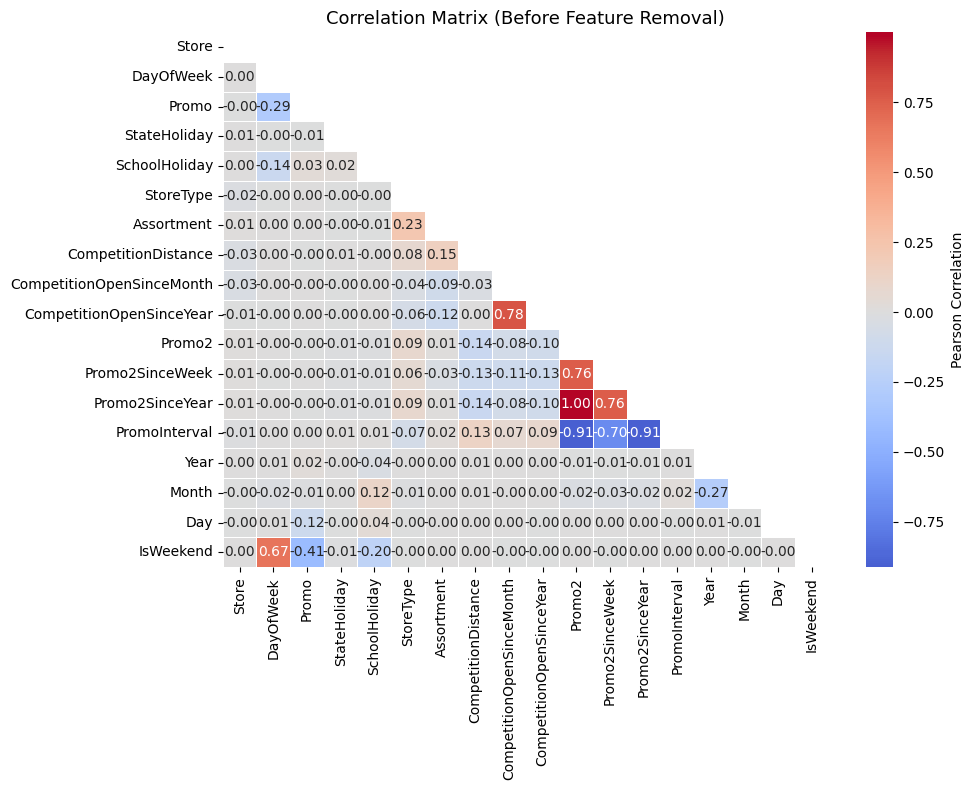

In [17]:
# ================================================================
# TRIANGULAR CORRELATION HEATMAP — BEFORE AND AFTER FEATURE REMOVAL
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================================================================
#  Correlation Matrix (Before Feature Removal)
# ================================================================
corr_before = X.corr()

print(" Initial Correlation Matrix (Before Feature Removal):")
display(corr_before)

# Mask for upper triangle (щоб залишити лише нижню половину)
mask = np.triu(np.ones_like(corr_before, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_before,
    mask=mask,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Pearson Correlation"}
)
plt.title("Correlation Matrix (Before Feature Removal)", fontsize=13)
plt.tight_layout()
plt.show()



\ Detected highly correlated features (correlation > 0.9):
['Promo2SinceYear', 'PromoInterval']

 Correlation Matrix (After Feature Removal):


<>:8: SyntaxWarning: invalid escape sequence '\ '
<>:8: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2087758695.py:8: SyntaxWarning: invalid escape sequence '\ '
  print("\ Detected highly correlated features (correlation > 0.9):")


Store  DayOfWeek     Promo  StateHoliday  \
Store                      1.000000   0.000007 -0.004341      0.005665   
DayOfWeek                  0.000007   1.000000 -0.291773     -0.004659   
Promo                     -0.004341  -0.291773  1.000000     -0.006900   
StateHoliday               0.005665  -0.004659 -0.006900      1.000000   
SchoolHoliday              0.001988  -0.138165  0.029729      0.023351   
StoreType                 -0.022318  -0.004349  0.001714     -0.004057   
Assortment                 0.010595   0.000931  0.001996     -0.000931   
CompetitionDistance       -0.027001   0.002833 -0.003279      0.005491   
CompetitionOpenSinceMonth -0.030882  -0.000707 -0.000492     -0.002944   
CompetitionOpenSinceYear  -0.006006  -0.004162  0.000052     -0.004783   
Promo2                     0.007460  -0.000612 -0.003972     -0.011951   
Promo2SinceWeek            0.008616  -0.002020 -0.000770     -0.011428   
Year                       0.001264   0.005979  0.024009     -0.000422   
Month                     -0.001143  -0.019118 -0.009328      0.004331   
Day                       -0.002844   0.006336 -0.124097     -0.002321   
IsWeekend                  0.001006   0.669205 -0.414819     -0.013184   

                           SchoolHoliday  StoreType  Assortment  \
Store                           0.001988  -0.022318    0.010595   
DayOfWeek                      -0.138165  -0.004349    0.000931   
Promo                           0.029729   0.001714    0.001996   
StateHoliday                    0.023351  -0.004057   -0.000931   
SchoolHoliday                   1.000000  -0.002762   -0.006281   
StoreType                      -0.002762   1.000000    0.227554   
Assortment                     -0.006281   0.227554    1.000000   
CompetitionDistance            -0.000065   0.076063    0.148535   
CompetitionOpenSinceMonth       0.001698  -0.036702   -0.093458   
CompetitionOpenSinceYear        0.003802  -0.062592   -0.119310   
Promo2                         -0.013184   0.086957    0.008661   
Promo2SinceWeek                -0.008586   0.057260   -0.032444   
Year                           -0.035632  -0.000796    0.004396   
Month                           0.118606  -0.010182    0.003908   
Day                             0.040666  -0.002468   -0.000713   
IsWeekend                      -0.203353  -0.004503    0.003513   

                           CompetitionDistance  CompetitionOpenSinceMonth  \
Store                                -0.027001                  -0.030882   
DayOfWeek                             0.002833                  -0.000707   
Promo                                -0.003279                  -0.000492   
StateHoliday                          0.005491                  -0.002944   
SchoolHoliday                        -0.000065                   0.001698   
StoreType                             0.076063                  -0.036702   
Assortment                            0.148535                  -0.093458   
CompetitionDistance                   1.000000                  -0.028552   
CompetitionOpenSinceMonth            -0.028552                   1.000000   
CompetitionOpenSinceYear              0.001761                   0.784247   
Promo2                               -0.143062                  -0.081344   
Promo2SinceWeek                      -0.126889                  -0.108544   
Year                                  0.005596                   0.002956   
Month                                 0.006055                  -0.000032   
Day                                   0.001511                   0.000512   
IsWeekend                             0.003492                  -0.002331   

                           CompetitionOpenSinceYear    Promo2  \
Store                                     -0.006006  0.007460   
DayOfWeek                                 -0.004162 -0.000612   
Promo                                      0.000052 -0.003972   
StateHoliday                              -0.004783 -0.011951

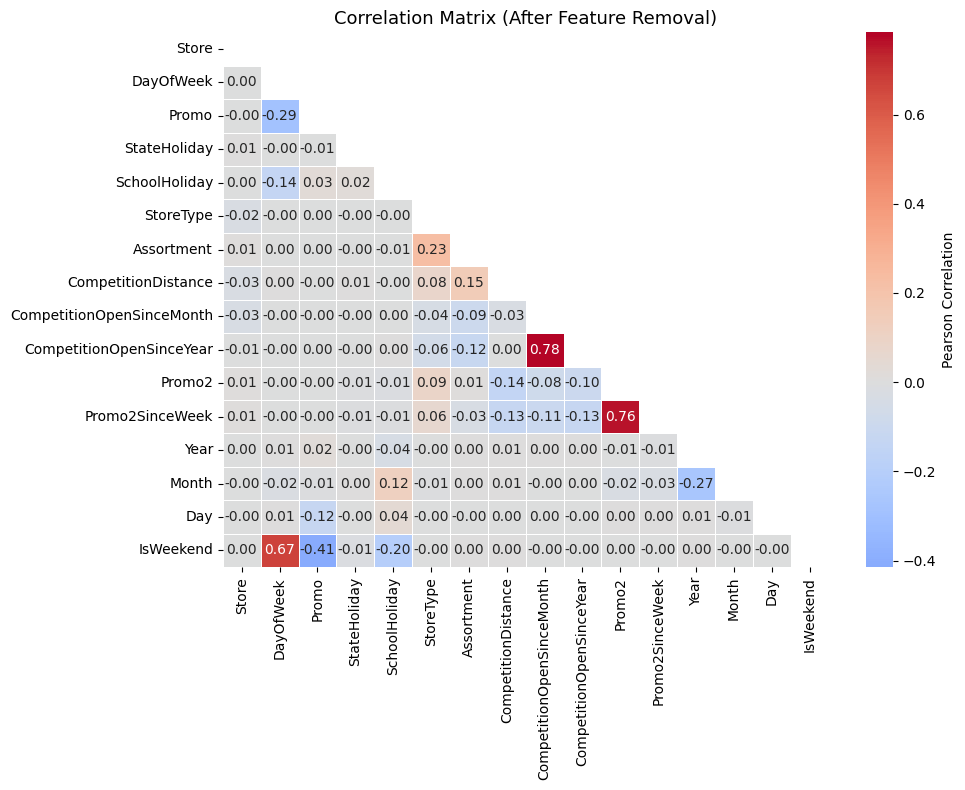


Number of numerical features before cleaning: 18
Number of numerical features after cleaning:  16


In [18]:
# ================================================================
#  Identify and Remove Highly Correlated Features (> 0.9)
# ================================================================
corr_matrix = corr_before.abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

print("\ Detected highly correlated features (correlation > 0.9):")
print(to_drop if to_drop else "No features to remove")

# Drop correlated columns if any
if to_drop:
    X.drop(columns=to_drop, inplace=True)


# ================================================================
#  Correlation Matrix (After Feature Removal)
# ================================================================
corr_after = X.corr()

print("\n Correlation Matrix (After Feature Removal):")
display(corr_after)

mask_after = np.triu(np.ones_like(corr_after, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_after,
    mask=mask_after,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Pearson Correlation"}
)
plt.title("Correlation Matrix (After Feature Removal)", fontsize=13)
plt.tight_layout()
plt.show()


# ================================================================
#  Summary of Changes
# ================================================================
print(f"\nNumber of numerical features before cleaning: {corr_before.shape[0]}")
print(f"Number of numerical features after cleaning:  {corr_after.shape[0]}")


In [19]:
# ==============================
# Train/Test Split and Scaling
# ==============================
# Split data (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain/Test shapes: {X_train.shape}, {X_test.shape}")


Train/Test shapes: (135038, 16), (33760, 16)


In [20]:
# ================================================================
# EVALUATION METRICS
# ================================================================

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt
import seaborn as sns

def wape(y_true, y_pred):
    """Weighted Absolute Percentage Error."""
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error (in %)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error (in %)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    denominator[denominator == 0] = 1e-8  # avoid division by zero
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / denominator)

def evaluate_model(name, model, X_test, y_test, start_time):
    """Evaluate model performance and return metrics."""
    y_pred = model.predict(X_test)
    end_time = time.time()

    return {
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred),
        "WAPE": wape(y_test, y_pred),
        "MAPE": mape(y_test, y_pred),
        # "sMAPE": smape(y_test, y_pred),  # optional if needed
        "Time (s)": round(end_time - start_time, 2)
    }, y_pred

def plot_actual_vs_predicted(y_true, y_pred, model_name, n_points=200):
    """Display two separate plots for each model: line and scatter."""
    df_comp = pd.DataFrame({"Actual": y_true, "Predicted": y_pred})

    # ------------------------------------------------
    #  Line Plot — Actual vs Predicted
    # ------------------------------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(df_comp["Actual"].values[:n_points], label="Actual", color="steelblue", linewidth=2)
    plt.plot(df_comp["Predicted"].values[:n_points], label="Predicted", color="tomato", linestyle="--", linewidth=2)
    plt.title(f"{model_name}: Actual vs Predicted Sales (First {n_points} Observations)")
    plt.xlabel("Observation Index")
    plt.ylabel("Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------
    #  Scatter Plot — Correlation between Actual and Predicted
    # ------------------------------------------------
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        x="Actual",
        y="Predicted",
        data=df_comp,
        alpha=0.6,
        color="slateblue",
        edgecolor=None
    )
    plt.plot(
        [df_comp["Actual"].min(), df_comp["Actual"].max()],
        [df_comp["Actual"].min(), df_comp["Actual"].max()],
        color="red",
        linestyle="--",
        linewidth=2,
        label="Ideal Line (y = x)"
    )
    plt.title(f"{model_name}: Actual vs Predicted Correlation")
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, model_name):
    """
    Generates histogram and scatter plots of residuals for a single model.
    """
    residuals = y_true - y_pred

    # --- HISTOGRAM OF RESIDUALS ---
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=40, kde=True, color="coral")
    plt.title(f"Distribution of Residuals — {model_name}")
    plt.xlabel("Residuals (Prediction Errors)")
    plt.ylabel("Number of Observations")
    plt.tight_layout()
    plt.show()

    # --- SCATTER PLOT OF RESIDUALS VS ACTUAL VALUES ---
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=y_true, y=residuals, alpha=0.4, color="teal", edgecolor=None)
    plt.axhline(0, color="red", linestyle="--", linewidth=2)
    plt.title(f"Residuals vs Actual Sales — {model_name}")
    plt.xlabel("Actual Sales")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.tight_layout()
    plt.show()

In [21]:
# ==============================
# Default Parameters Inspection
# ==============================
models = [XGBRegressor, CatBoostRegressor, RandomForestRegressor]

for model_class in models:
    model = model_class()
    print(f"\n{model.__class__.__name__} — Default Parameters:")
    for param, value in model.get_params().items():
        print(f"{param}: {value}")


XGBRegressor — Default Parameters:
objective: reg:squarederror
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
feature_weights: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: None
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: None
n_jobs: None
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: None

CatBoostRegressor — Default Parameters:
loss_function: RMSE

RandomForestRegressor — Default Parameters:
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error

In [22]:
!nvidia-smi

Thu Nov 13 16:29:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             54W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

 Training XGBoost (default parameters)...
XGBoost — RMSE: 1175.53, R²: 0.858, WAPE: 0.118, MAPE: 13.419%


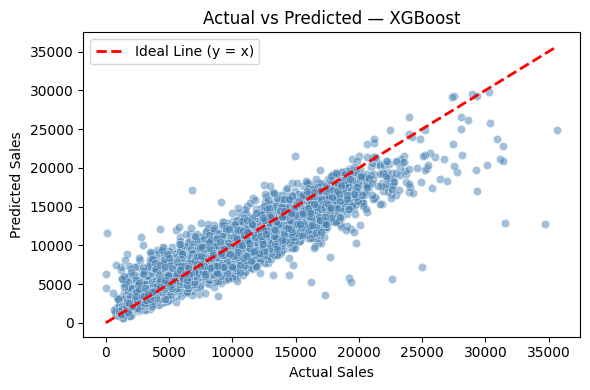

In [23]:
# ================================================================
# BASE MODELS EVALUATION — MODEL BY MODEL (with MAPE)
# ================================================================

import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# ================================================================
# DEFINE BASE MODELS
# ================================================================
models = {
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_seed=42, verbose=0),
    "RandomForest": RandomForestRegressor(random_state=42)
}

results_list = []


# ================================================================
# MODEL 1 — XGBOOST
# ================================================================
print(" Training XGBoost (default parameters)...")
start_time = time.time()
xgb_model = models["XGBoost"]
xgb_model.fit(X_train_scaled, y_train)
result, _ = evaluate_model("XGBoost", xgb_model, X_test_scaled, y_test, start_time)
results_list.append(result)
print(f"XGBoost — RMSE: {result['RMSE']:.2f}, R²: {result['R2']:.3f}, "
      f"WAPE: {result['WAPE']:.3f}, MAPE: {result['MAPE']:.3f}%")

# --- Visualization for XGBoost ---
y_pred_xgb = xgb_model.predict(X_test_scaled)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.5, color="steelblue")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Ideal Line (y = x)"
)
plt.title("Actual vs Predicted — XGBoost")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.legend()
plt.tight_layout()
plt.show()

 Training CatBoost (default parameters)...
CatBoost — RMSE: 1202.27, R²: 0.852, WAPE: 0.121, MAPE: 13.727%


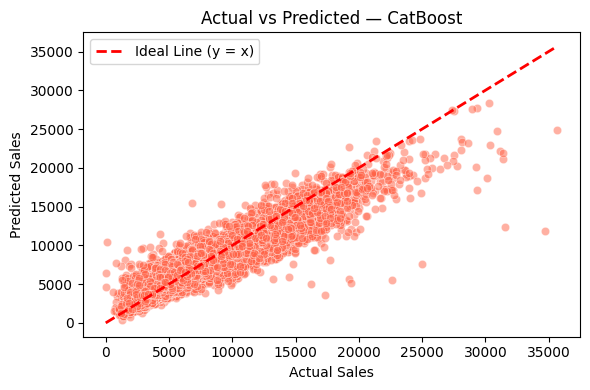

In [24]:
# ================================================================
# MODEL 2 — CATBOOST
# ================================================================
print(" Training CatBoost (default parameters)...")
start_time = time.time()
cat_model = models["CatBoost"]
cat_model.fit(X_train_scaled, y_train)
result, _ = evaluate_model("CatBoost", cat_model, X_test_scaled, y_test, start_time)
results_list.append(result)
print(f"CatBoost — RMSE: {result['RMSE']:.2f}, R²: {result['R2']:.3f}, "
      f"WAPE: {result['WAPE']:.3f}, MAPE: {result['MAPE']:.3f}%")

# --- Visualization for CatBoost ---
y_pred_cat = cat_model.predict(X_test_scaled)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_cat, alpha=0.5, color="tomato")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Ideal Line (y = x)"
)
plt.title("Actual vs Predicted — CatBoost")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.legend()
plt.tight_layout()
plt.show()

 Training RandomForest (default parameters)...
RandomForest — RMSE: 1148.99, R²: 0.865, WAPE: 0.104, MAPE: 11.073%


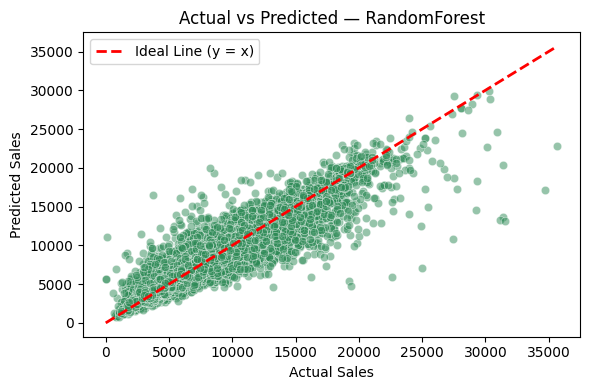

In [25]:
# ================================================================
# MODEL 3 — RANDOM FOREST
# ================================================================
print(" Training RandomForest (default parameters)...")
start_time = time.time()
rf_model = models["RandomForest"]
rf_model.fit(X_train_scaled, y_train)
result, _ = evaluate_model("RandomForest", rf_model, X_test_scaled, y_test, start_time)
results_list.append(result)
print(f"RandomForest — RMSE: {result['RMSE']:.2f}, R²: {result['R2']:.3f}, "
      f"WAPE: {result['WAPE']:.3f}, MAPE: {result['MAPE']:.3f}%")

# --- Visualization for RandomForest ---
y_pred_rf = rf_model.predict(X_test_scaled)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color="seagreen")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Ideal Line (y = x)"
)
plt.title("Actual vs Predicted — RandomForest")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# ================================================================
# RESULTS SUMMARY
# ================================================================
results_base = pd.DataFrame(results_list)
print("\n Base Model Results Summary:")
print(results_base[["Model", "MAE", "RMSE", "WAPE", "MAPE", "R2", "Time (s)"]])


 Base Model Results Summary:
          Model         MAE         RMSE      WAPE       MAPE        R2  \
0       XGBoost  823.814697  1175.530997  0.118360  13.419301  0.858497   
1      CatBoost  844.724479  1202.271103  0.121365  13.727004  0.851986   
2  RandomForest  724.676390  1148.989294  0.104117  11.072921  0.864814   

   Time (s)  
0      0.48  
1      5.42  
2     74.76  


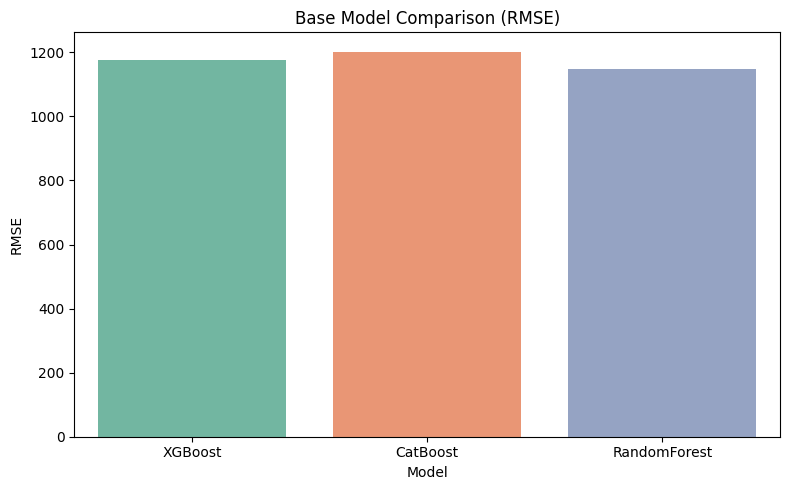

In [27]:
# --- Combined RMSE Comparison Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="RMSE", data=results_base, palette="Set2")
plt.title("Base Model Comparison (RMSE)")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

 Residual Analysis: CatBoost


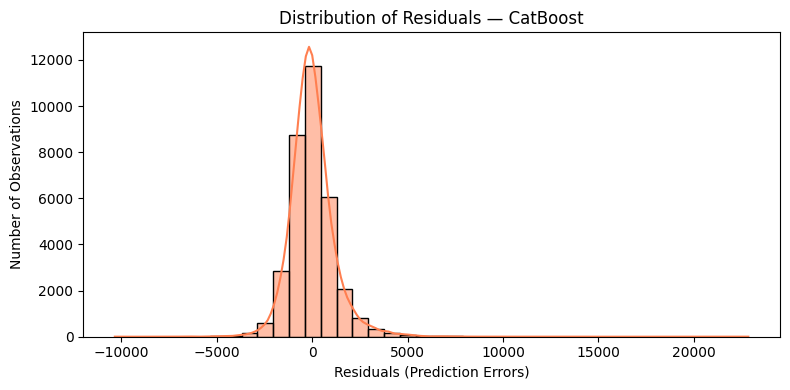

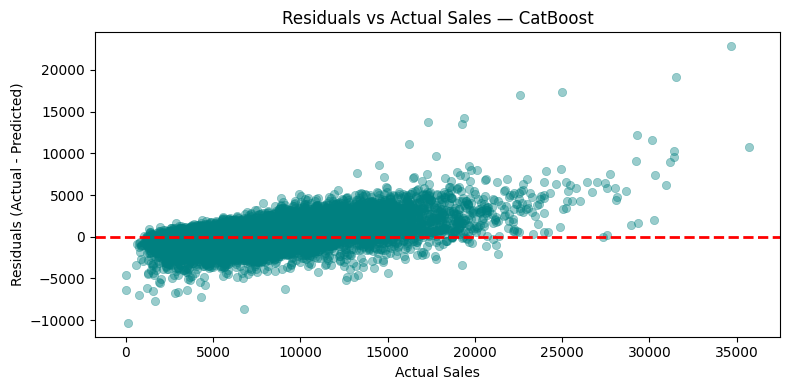

In [28]:
# ================================================================
# PREDICTION RESIDUALS ANALYSIS — MODEL BY MODEL
# ================================================================

import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals_single_model(model, X_test_scaled, y_test, model_name):
    """
    Generates histogram and scatter plots of residuals for a single model.
    """
    y_pred = model.predict(X_test_scaled)
    residuals = y_test - y_pred

    # --- HISTOGRAM OF RESIDUALS ---
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=40, kde=True, color="coral")
    plt.title(f"Distribution of Residuals — {model_name}")
    plt.xlabel("Residuals (Prediction Errors)")
    plt.ylabel("Number of Observations")
    plt.tight_layout()
    plt.show()

    # --- SCATTER PLOT OF RESIDUALS VS ACTUAL VALUES ---
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=y_test, y=residuals, alpha=0.4, color="teal", edgecolor=None)
    plt.axhline(0, color="red", linestyle="--", linewidth=2)
    plt.title(f"Residuals vs Actual Sales — {model_name}")
    plt.xlabel("Actual Sales")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.tight_layout()
    plt.show()


# ================================================================
# MODEL 1 — CATBOOST
# ================================================================
print(" Residual Analysis: CatBoost")
cat_model = models["CatBoost"]
plot_residuals_single_model(cat_model, X_test_scaled, y_test, "CatBoost")

 Residual Analysis: XGBoost


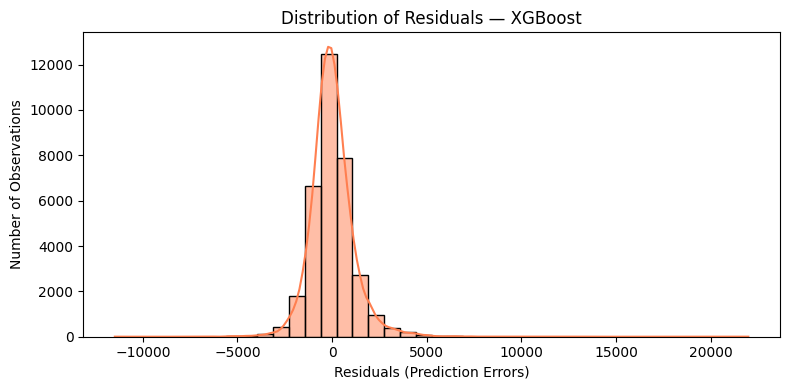

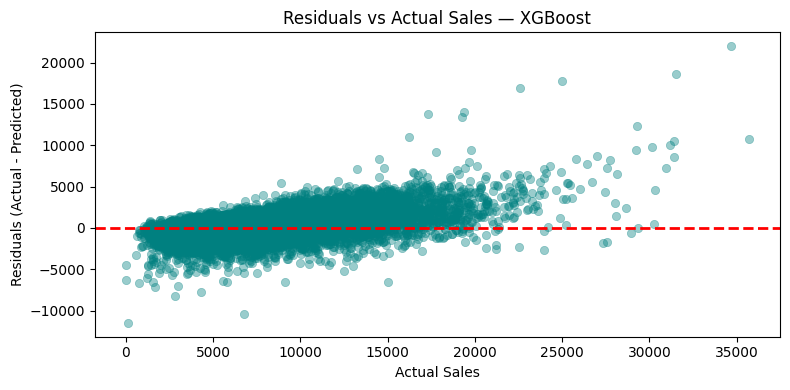

In [29]:
# ================================================================
# MODEL 2 — XGBOOST
# ================================================================
print(" Residual Analysis: XGBoost")
xgb_model = models["XGBoost"]
plot_residuals_single_model(xgb_model, X_test_scaled, y_test, "XGBoost")

 Residual Analysis: RandomForest


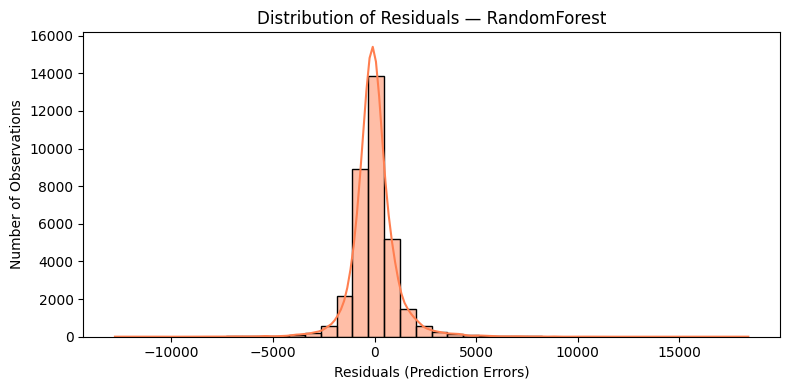

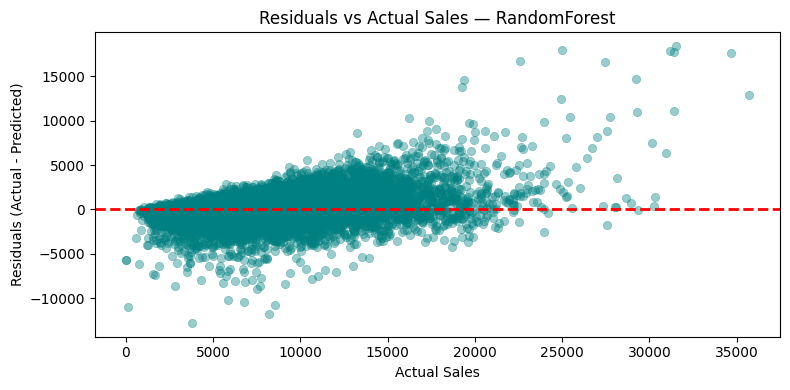

In [30]:
# ================================================================
# MODEL 3 — RANDOM FOREST
# ================================================================
print(" Residual Analysis: RandomForest")
rf_model = models["RandomForest"]
plot_residuals_single_model(rf_model, X_test_scaled, y_test, "RandomForest")

In [31]:
# ==============================
# Hyperparameter Tuning
# ==============================
# ------------------------------
# RandomForest (Grid Search)
# ------------------------------
print("\nRunning Grid Search for RandomForest...")

rf_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [None, 5, 7],
    "min_samples_split": [2, 5, 7]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1
)

grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
print("Best RandomForest parameters:", grid_rf.best_params_)

# ------------------------------
# CatBoost (OPTUNA)
# ------------------------------
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 8, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.15),
        "iterations": trial.suggest_int("iterations", 400, 500),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 8.0, 9.0),
        "task_type": "GPU",
        "devices": "0",
        "thread_count": -1
    }

    model = CatBoostRegressor(**params, random_seed=42, verbose=0)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    return np.sqrt(mean_squared_error(y_test, preds))

print("\nRunning Bayesian Optimization for CatBoost (GPU)...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

best_params_cat = study.best_params
print("Best CatBoost parameters:", best_params_cat)

# ------------------------------
# Final CatBoost Model
# ------------------------------
best_cat = CatBoostRegressor(
    **best_params_cat,
    random_seed=42,
    verbose=0,
    task_type="GPU"
)
best_cat.fit(X_train_scaled, y_train)

preds = best_cat.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Final CatBoost RMSE on test set: {rmse:.4f}")


Running Grid Search for RandomForest...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2025-11-13 16:45:38,995] A new study created in memory with name: no-name-45d0c46d-8cd7-4e20-8a26-e0cb35cf69cf


Best RandomForest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400}

Running Bayesian Optimization for CatBoost (GPU)...


[I 2025-11-13 16:45:41,286] Trial 0 finished with value: 1029.8552044641299 and parameters: {'depth': 10, 'learning_rate': 0.11689287396073406, 'iterations': 400, 'l2_leaf_reg': 8.820168425664182}. Best is trial 0 with value: 1029.8552044641299.
[I 2025-11-13 16:45:45,330] Trial 1 finished with value: 1101.5468285166328 and parameters: {'depth': 9, 'learning_rate': 0.10068545746615834, 'iterations': 464, 'l2_leaf_reg': 8.62796995716077}. Best is trial 0 with value: 1029.8552044641299.
[I 2025-11-13 16:45:49,056] Trial 2 finished with value: 1098.1435916856572 and parameters: {'depth': 8, 'learning_rate': 0.1317058614355847, 'iterations': 479, 'l2_leaf_reg': 8.133304157795482}. Best is trial 0 with value: 1029.8552044641299.
[I 2025-11-13 16:45:52,815] Trial 3 finished with value: 1083.5076746329698 and parameters: {'depth': 8, 'learning_rate': 0.13187660825147107, 'iterations': 485, 'l2_leaf_reg': 8.752963274009092}. Best is trial 0 with value: 1029.8552044641299.
[I 2025-11-13 16:45:5

Best CatBoost parameters: {'depth': 10, 'learning_rate': 0.1443263011149883, 'iterations': 461, 'l2_leaf_reg': 8.324442140638345}
Final CatBoost RMSE on test set: 960.9877


In [32]:
# ================================================================
# CATBOOST MODEL EVALUATION (GPU)
# ================================================================

# Generate predictions (if not already done)
# preds = best_cat.predict(X_test_scaled)

# Compute evaluation metrics
r2_cat = r2_score(y_test, preds)
mae_cat = mean_absolute_error(y_test, preds)
rmse_cat = np.sqrt(mean_squared_error(y_test, preds))
wape_cat = wape(y_test, preds)
mape_cat = mape(y_test, preds)
# smape_cat = smape(y_test, preds)

# Display results
print("\nCatBoost Performance Metrics:")
print(f"R²:    {r2_cat:.4f}")
print(f"MAE:   {mae_cat:.4f}")
print(f"RMSE:  {rmse_cat:.4f}")
print(f"WAPE:  {wape_cat:.4f}")
print(f"MAPE:  {mape_cat:.4f}%")


CatBoost Performance Metrics:
R²:    0.9054
MAE:   652.5839
RMSE:  960.9877
WAPE:  0.0938
MAPE:  10.4839%


In [33]:
## ================================================================
# RANDOM FOREST MODEL EVALUATION
# ================================================================

# Generate predictions
preds_rf = best_rf.predict(X_test_scaled)

# Compute evaluation metrics
r2_rf = r2_score(y_test, preds_rf)
mae_rf = mean_absolute_error(y_test, preds_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, preds_rf))
wape_rf = wape(y_test, preds_rf)
mape_rf = mape(y_test, preds_rf)

# Display results
print("\nRandomForest Performance Metrics:")
print(f"R²:    {r2_rf:.4f}")
print(f"MAE:   {mae_rf:.4f}")
print(f"RMSE:  {rmse_rf:.4f}")
print(f"WAPE:  {wape_rf:.4f}")
print(f"MAPE:  {mape_rf:.4f}%")


RandomForest Performance Metrics:
R²:    0.8665
MAE:   719.5971
RMSE:  1141.9006
WAPE:  0.1034
MAPE:  10.9877%


In [34]:
# ================================================================
# ENSEMBLE MODELS (GPU OPTIMIZED)
# ================================================================


print("\nBuilding ensemble models...")
start_time = time.time()

# ------------------------------
# Base Models (GPU + CPU)
# ------------------------------

# CatBoost (GPU)
cat = CatBoostRegressor(
    **best_params_cat,
    random_seed=42,
    verbose=0,
    task_type="GPU",
    devices="0"
)

# LightGBM (GPU)
lgb = LGBMRegressor(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    device="gpu",
    gpu_platform_id=0,
    gpu_device_id=0
)

# ElasticNet (CPU)
enet = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000)

# ------------------------------
# Train base models
# ------------------------------
cat.fit(X_train_scaled, y_train)
lgb.fit(X_train_scaled, y_train)
enet.fit(X_train_scaled, y_train)

# ------------------------------
# Predictions
# ------------------------------
pred_cat = cat.predict(X_test_scaled)
pred_lgb = lgb.predict(X_test_scaled)
pred_enet = enet.predict(X_test_scaled)

# ------------------------------
# Weighted Ensemble
# ------------------------------
weights = [0.5, 0.3, 0.2]
pred_weighted = np.average(
    [pred_cat, pred_lgb, pred_enet],
    axis=0,
    weights=weights
)

ensemble_weighted = {
    "Model": "Weighted Ensemble (GPU)",
    "MAE": mean_absolute_error(y_test, pred_weighted),
    "RMSE": np.sqrt(mean_squared_error(y_test, pred_weighted)),
    "R2": r2_score(y_test, pred_weighted),
    "WAPE": wape(y_test, pred_weighted),
    "MAPE": mape(y_test, pred_weighted),
    "Time (s)": round(time.time() - start_time, 2)
}
results_list.append(ensemble_weighted)

# ------------------------------
# Stacked Ensemble (GPU base + CPU meta)
# ------------------------------
stack_train = np.column_stack([
    cat.predict(X_train_scaled),
    lgb.predict(X_train_scaled),
    enet.predict(X_train_scaled)
])
stack_test = np.column_stack([pred_cat, pred_lgb, pred_enet])

meta_model = LinearRegression()
meta_model.fit(stack_train, y_train)
pred_stack = meta_model.predict(stack_test)

ensemble_stacked = {
    "Model": "Stacked Ensemble (GPU base + CPU meta)",
    "MAE": mean_absolute_error(y_test, pred_stack),
    "RMSE": np.sqrt(mean_squared_error(y_test, pred_stack)),
    "R2": r2_score(y_test, pred_stack),
    "WAPE": wape(y_test, pred_stack),
    "MAPE": mape(y_test, pred_stack),
    "Time (s)": round(time.time() - start_time, 2)
}
results_list.append(ensemble_stacked)

print(" Ensembles built successfully and results added to results_list.")


Building ensemble models...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 135038, number of used features: 16
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-80GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (2.06 MB) transferred to GPU in 0.003056 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 6953.307936


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


 Ensembles built successfully and results added to results_list.


In [35]:
# ================================================================
# FINAL RESULTS — SORTED AND STYLED
# ================================================================

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

# Sort models by RMSE (best → worst)
results_df = results_df.sort_values(by="RMSE", ascending=True).reset_index(drop=True)

# Display full results table including MAPE
print("\n Final Model Evaluation Results:")
display(results_df[["Model", "RMSE", "MAE", "WAPE", "MAPE", "R2", "Time (s)"]])

# Styled table with gradient highlighting for error metrics
results_df.style.background_gradient(
    subset=["RMSE", "MAE", "WAPE", "MAPE"],
    cmap="YlOrRd_r"
)


 Final Model Evaluation Results:


Model         RMSE         MAE      WAPE  \
0  Stacked Ensemble (GPU base + CPU meta)   933.671130  642.481034  0.092308   
1                            RandomForest  1148.989294  724.676390  0.104117   
2                                 XGBoost  1175.530997  823.814697  0.118360   
3                                CatBoost  1202.271103  844.724479  0.121365   
4                 Weighted Ensemble (GPU)  1338.448899  948.390784  0.136259   

        MAPE        R2  Time (s)  
0  10.356920  0.910734      9.75  
1  11.072921  0.864814     74.76  
2  13.419301  0.858497      0.48  
3  13.727004  0.851986      5.42  
4  15.797928  0.816557      9.11

 Actual vs Predicted — RandomForest (Tuned)


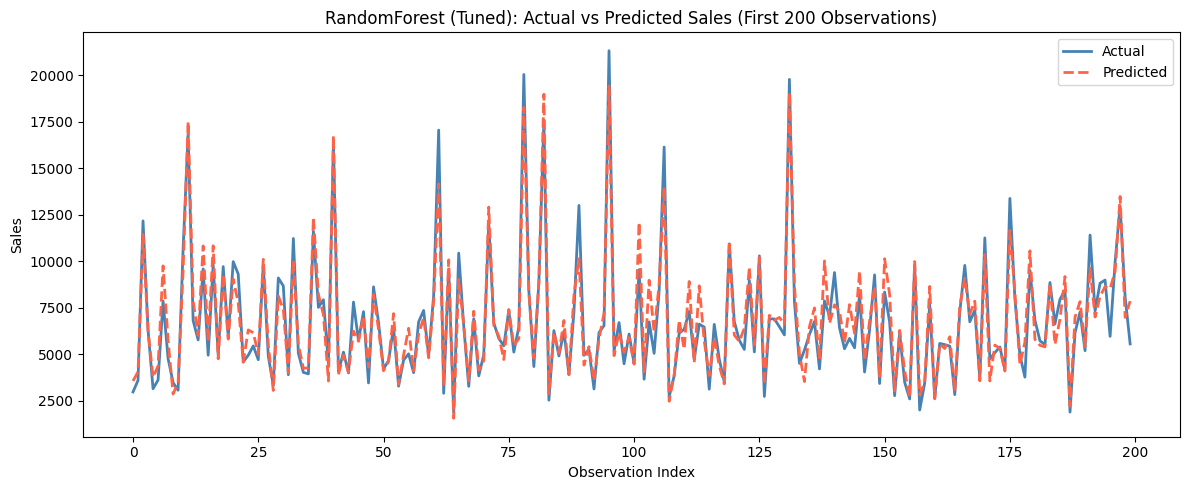

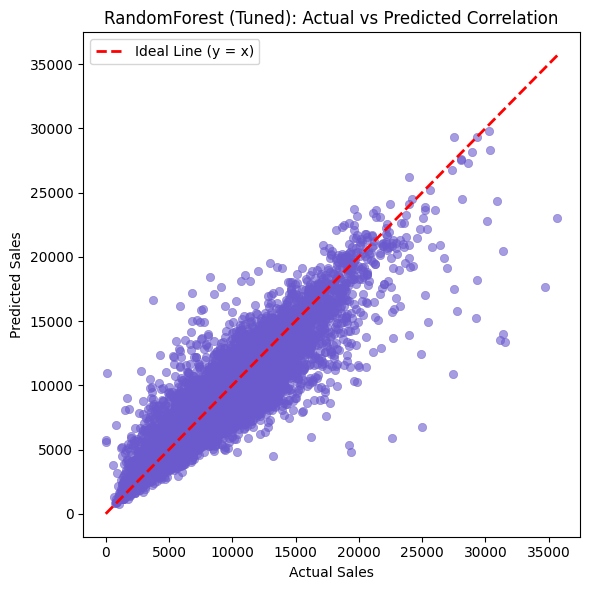

 Residuals — RandomForest (Tuned)


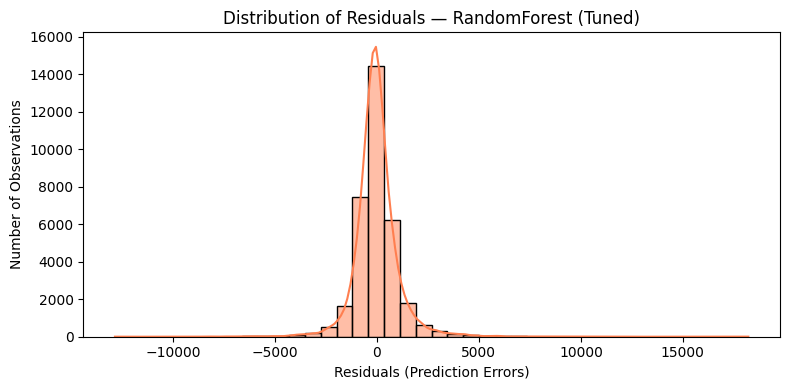

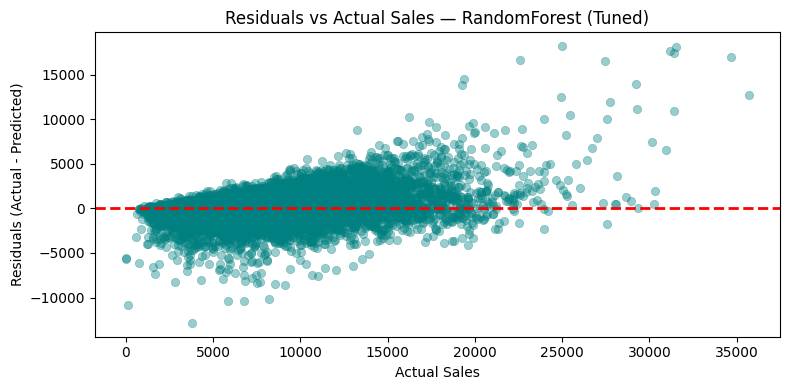

In [36]:
# ================================================================
# ACTUAL VS PREDICTED — TUNED AND ENSEMBLE MODELS
# ================================================================

# ------------------------------------------------
#  RandomForest (Tuned)
# ------------------------------------------------
print(" Actual vs Predicted — RandomForest (Tuned)")
y_pred_rf = best_rf.predict(X_test_scaled)
plot_actual_vs_predicted(y_test, y_pred_rf, "RandomForest (Tuned)")

print(" Residuals — RandomForest (Tuned)")
plot_residuals(y_test, y_pred_rf, "RandomForest (Tuned)")

 Actual vs Predicted — CatBoost (Tuned)


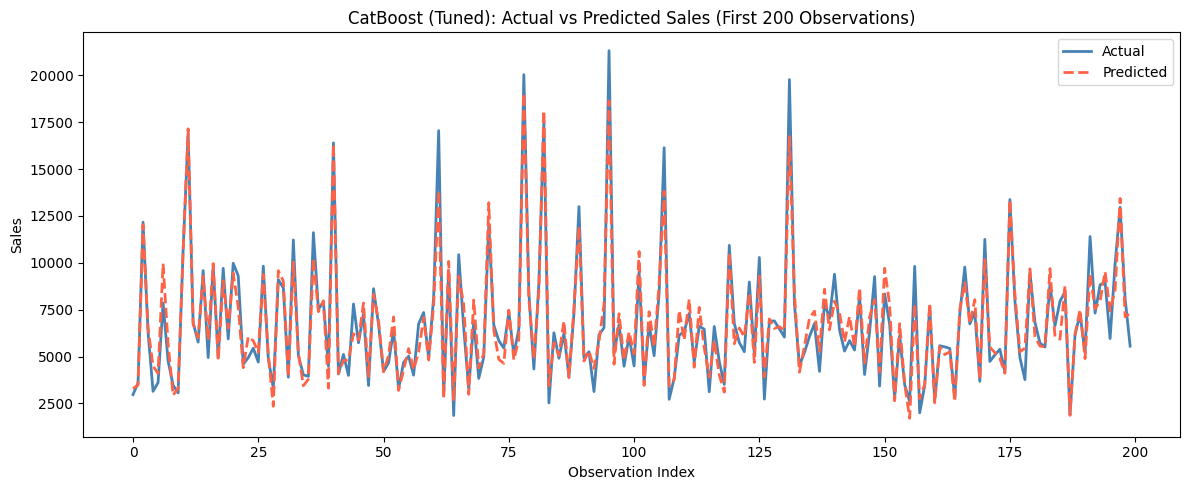

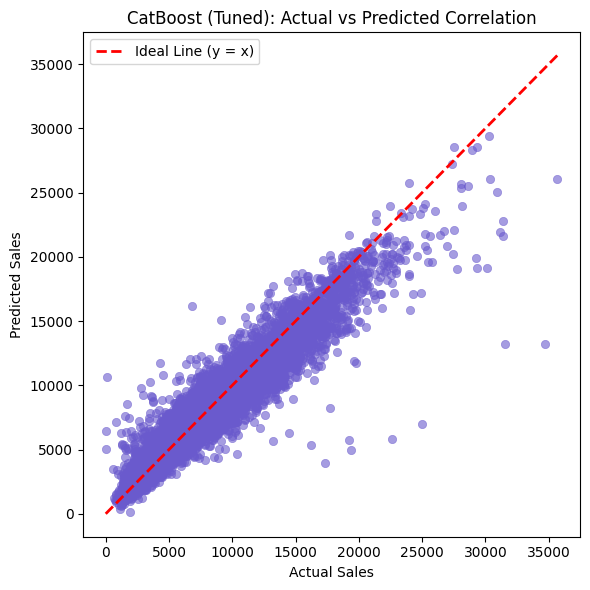

 Residuals — CatBoost (Tuned)


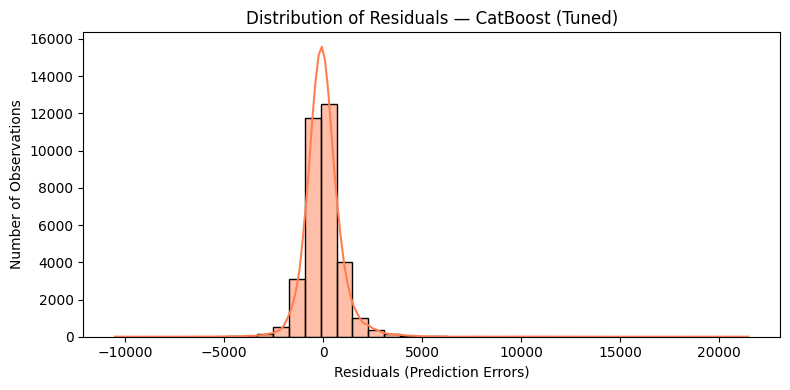

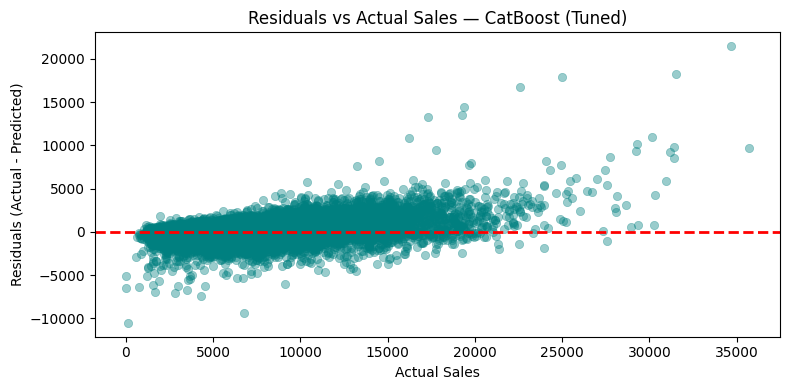

In [37]:
# ------------------------------------------------
#  CatBoost (Tuned)
# ------------------------------------------------
print(" Actual vs Predicted — CatBoost (Tuned)")
y_pred_cat = best_cat.predict(X_test_scaled)
plot_actual_vs_predicted(y_test, y_pred_cat, "CatBoost (Tuned)")

print(" Residuals — CatBoost (Tuned)")
plot_residuals(y_test, y_pred_cat, "CatBoost (Tuned)")

 Actual vs Predicted — Weighted Ensemble


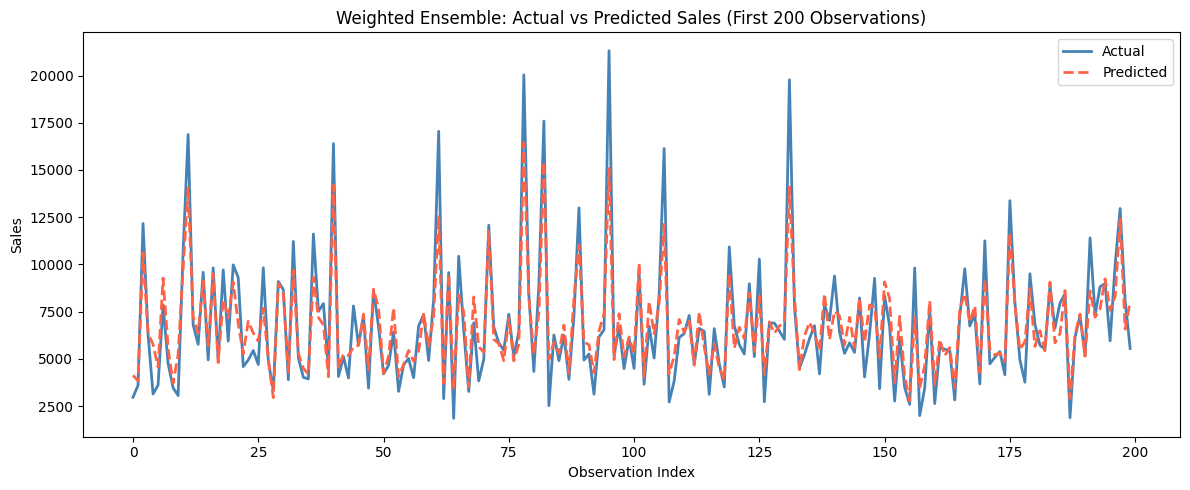

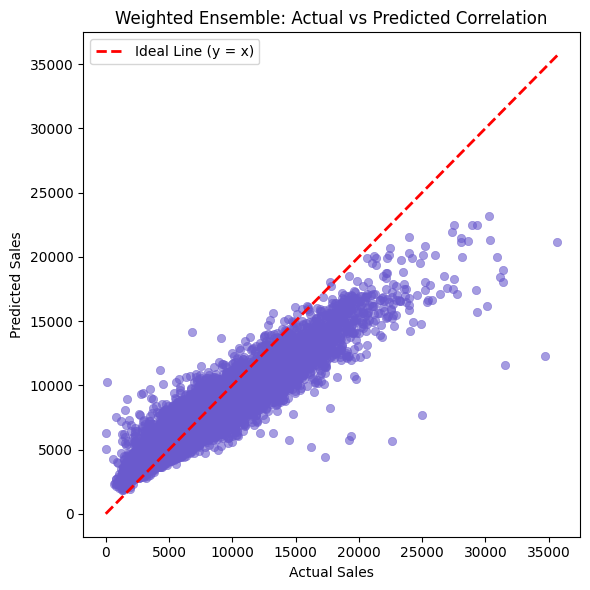

 Residuals — Weighted Ensemble


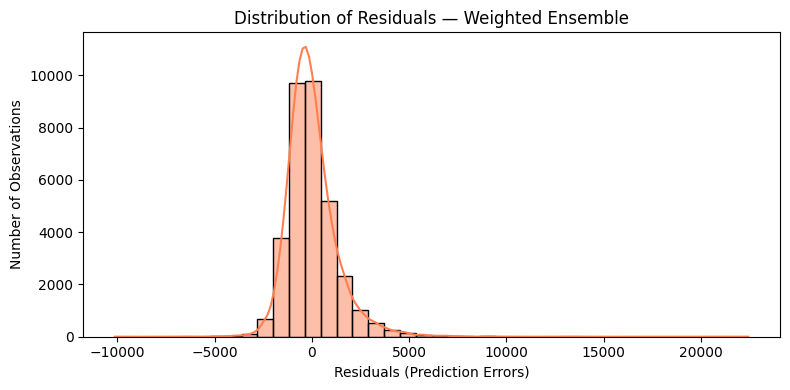

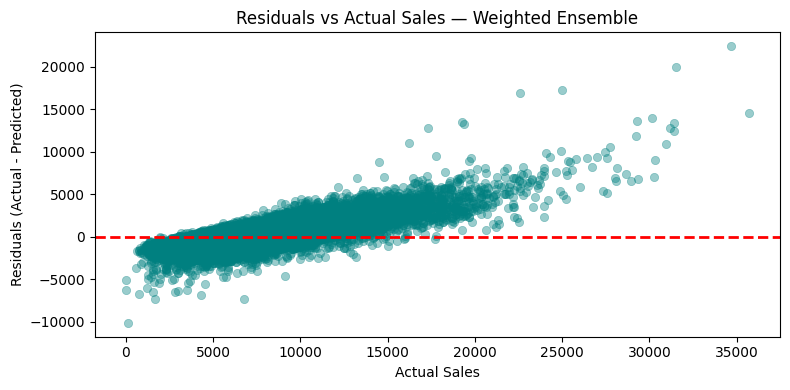

In [38]:
# ------------------------------------------------
#  Weighted Ensemble
# ------------------------------------------------
print(" Actual vs Predicted — Weighted Ensemble")
plot_actual_vs_predicted(y_test, pred_weighted, "Weighted Ensemble")

print(" Residuals — Weighted Ensemble")
plot_residuals(y_test, pred_weighted, "Weighted Ensemble")

 Actual vs Predicted — Stacked Ensemble


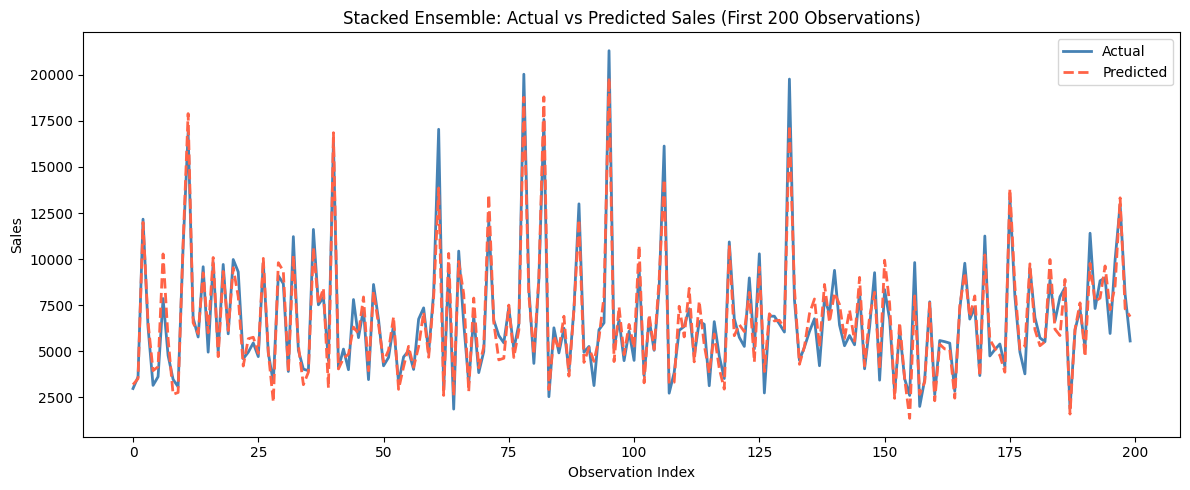

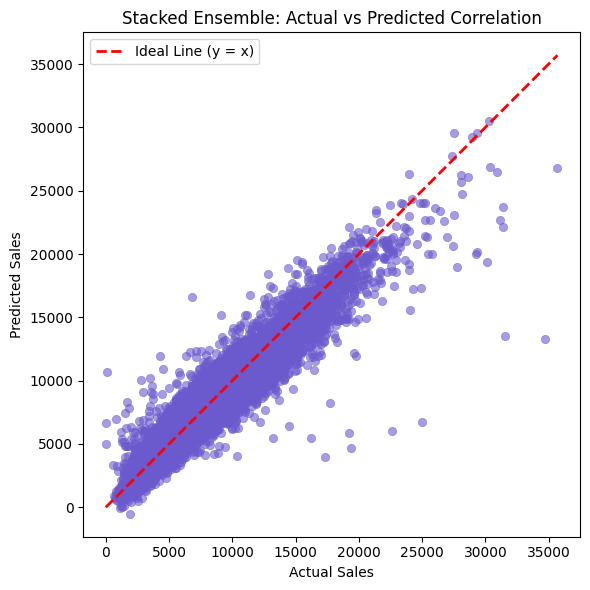

 Residuals — Stacked Ensemble


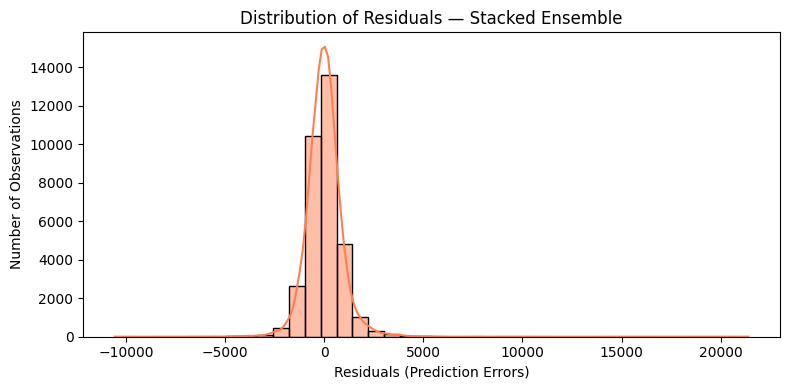

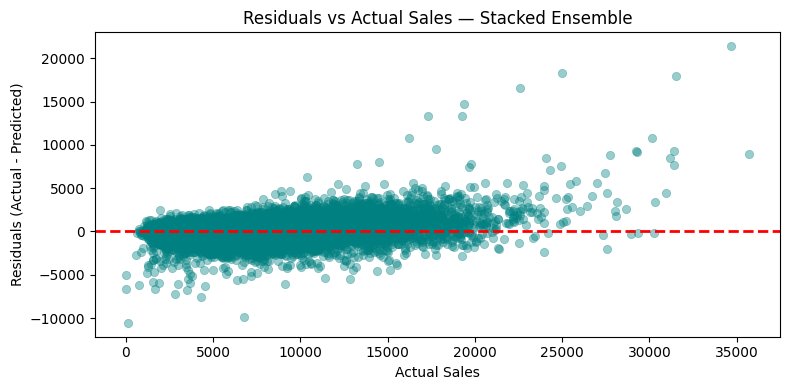

In [39]:
# ------------------------------------------------
# Stacked Ensemble
# ------------------------------------------------
print(" Actual vs Predicted — Stacked Ensemble")
plot_actual_vs_predicted(y_test, pred_stack, "Stacked Ensemble")

print(" Residuals — Stacked Ensemble")
plot_residuals(y_test, pred_stack, "Stacked Ensemble")


 XGBoost (Base) — Actual vs Predicted


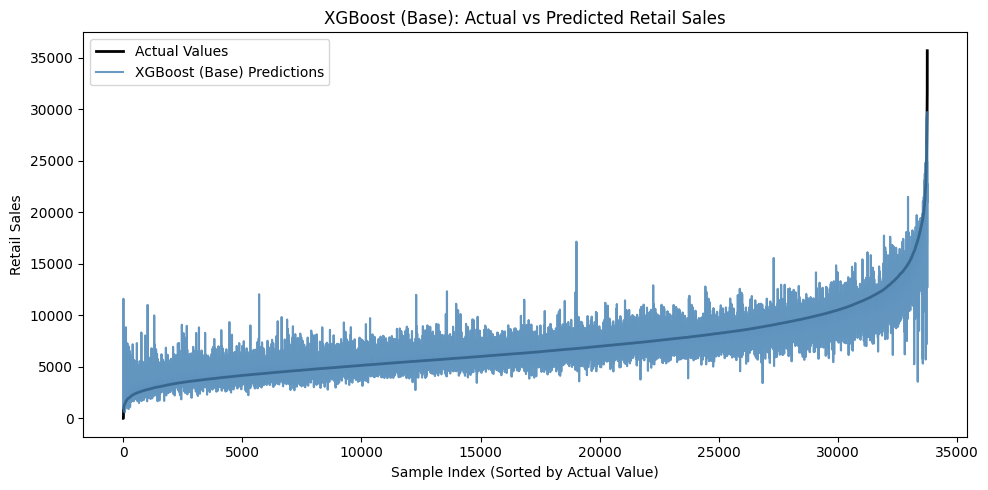

 XGBoost (Base) — Residuals


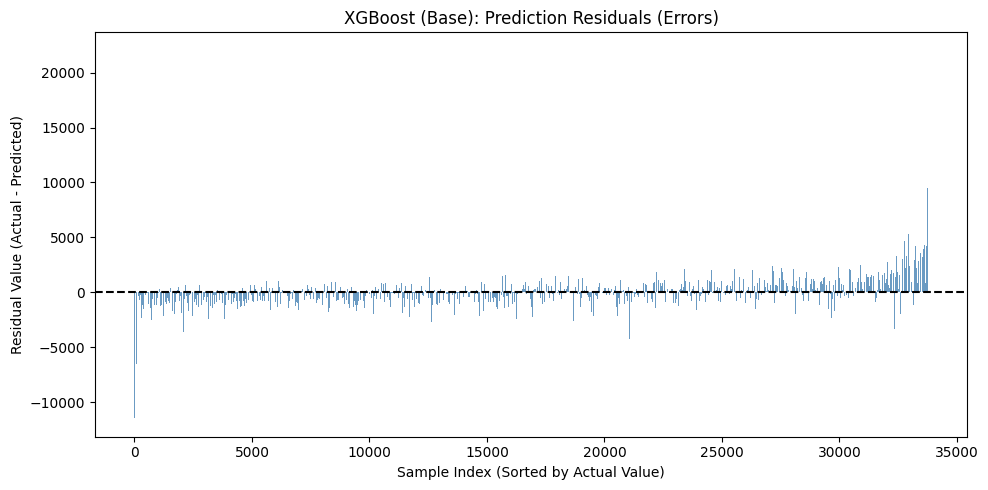


 CatBoost (Base) — Actual vs Predicted


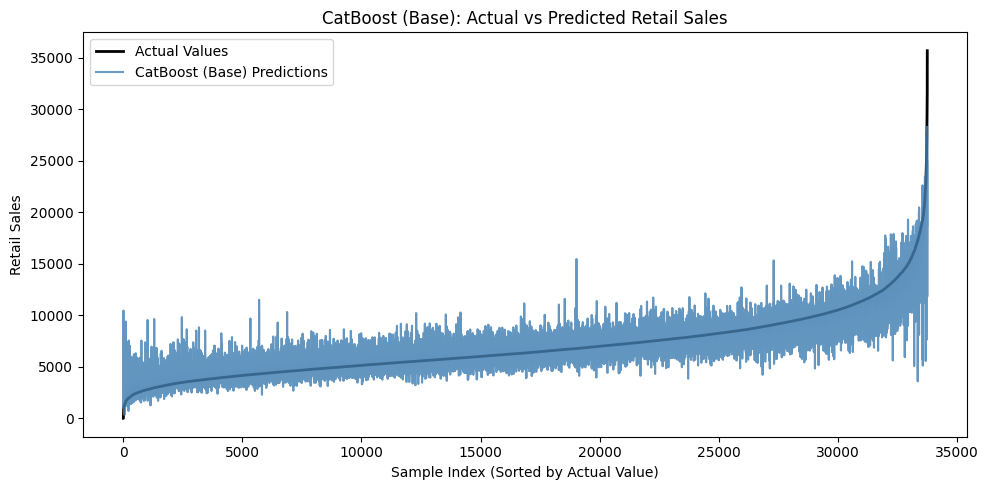

 CatBoost (Base) — Residuals


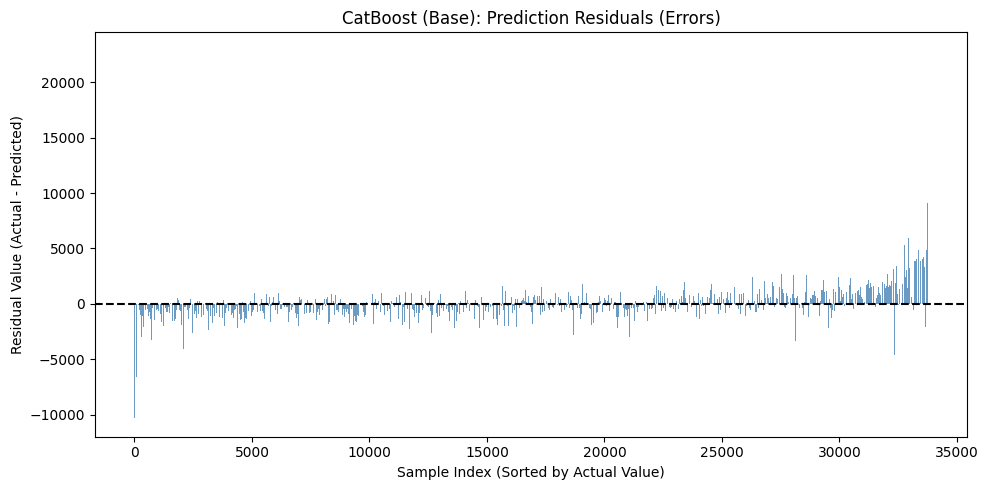


 RandomForest (Base) — Actual vs Predicted


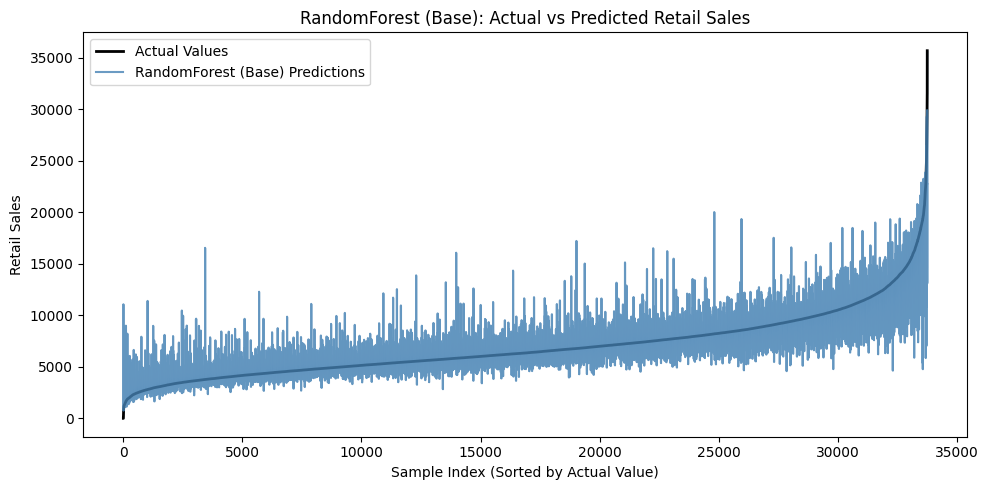

 RandomForest (Base) — Residuals


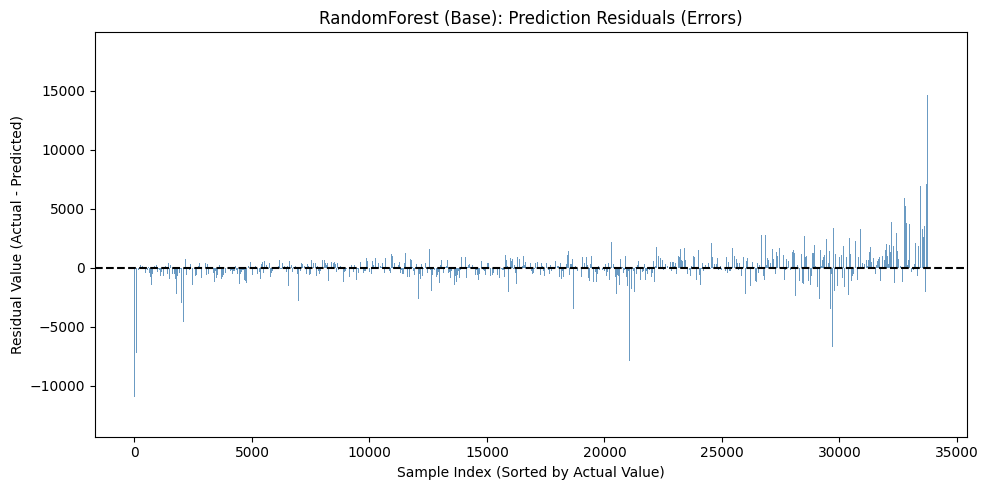

In [40]:
# ================================================================
# VISUALIZATION: Actual vs Predicted and Residuals (Errors)
# for Base, Tuned, and Ensemble Models
# ================================================================

def plot_sorted_actual_vs_predicted(y_true, y_pred, model_name, color_actual="black", color_pred="orange"):
    """Line plot: Actual vs Predicted values (sorted by Actual)."""
    df_plot = pd.DataFrame({"Actual": y_true, "Predicted": y_pred}).sort_values(by="Actual").reset_index(drop=True)

    plt.figure(figsize=(10, 5))
    plt.plot(df_plot["Actual"], label="Actual Values", color=color_actual, linewidth=2)
    plt.plot(df_plot["Predicted"], label=f"{model_name} Predictions", color=color_pred, alpha=0.8)
    plt.fill_between(df_plot.index, df_plot["Predicted"], df_plot["Actual"], color=color_pred, alpha=0.2)

    plt.title(f"{model_name}: Actual vs Predicted Retail Sales", fontsize=12)
    plt.xlabel("Sample Index (Sorted by Actual Value)")
    plt.ylabel("Retail Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_sorted_residuals(y_true, y_pred, model_name, color="red"):
    """Bar plot of residuals (errors), sorted by Actual."""
    df_plot = pd.DataFrame({
        "Actual": y_true,
        "Predicted": y_pred,
        "Residuals": y_true - y_pred
    }).sort_values(by="Actual").reset_index(drop=True)

    plt.figure(figsize=(10, 5))
    plt.bar(df_plot.index, df_plot["Residuals"], color=color, alpha=0.8)
    plt.axhline(0, color="black", linestyle="--", linewidth=1.5)

    plt.title(f"{model_name}: Prediction Residuals (Errors)", fontsize=12)
    plt.xlabel("Sample Index (Sorted by Actual Value)")
    plt.ylabel("Residual Value (Actual - Predicted)")
    plt.tight_layout()
    plt.show()


# ================================================================
# MODEL-BY-MODEL VISUALIZATION
# ================================================================

# ------------------------------------------------
#  BASE MODELS
# ------------------------------------------------
base_models = {
    "XGBoost (Base)": models["XGBoost"],
    "CatBoost (Base)": models["CatBoost"],
    "RandomForest (Base)": models["RandomForest"]
}

for name, model in base_models.items():
    print(f"\n {name} — Actual vs Predicted")
    y_pred = model.predict(X_test_scaled)
    plot_sorted_actual_vs_predicted(y_test, y_pred, name, color_pred="steelblue")

    print(f" {name} — Residuals")
    plot_sorted_residuals(y_test, y_pred, name, color="steelblue")


 RandomForest (Tuned) — Actual vs Predicted


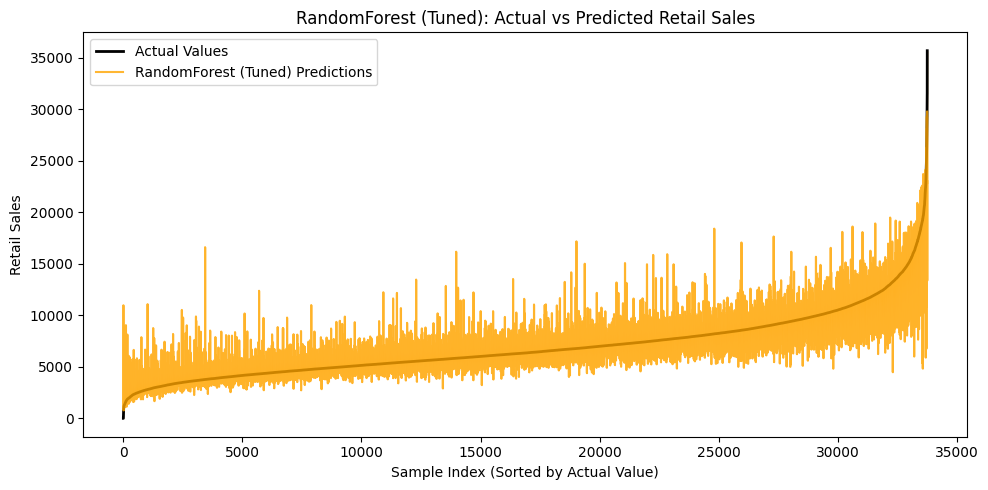

 RandomForest (Tuned) — Residuals


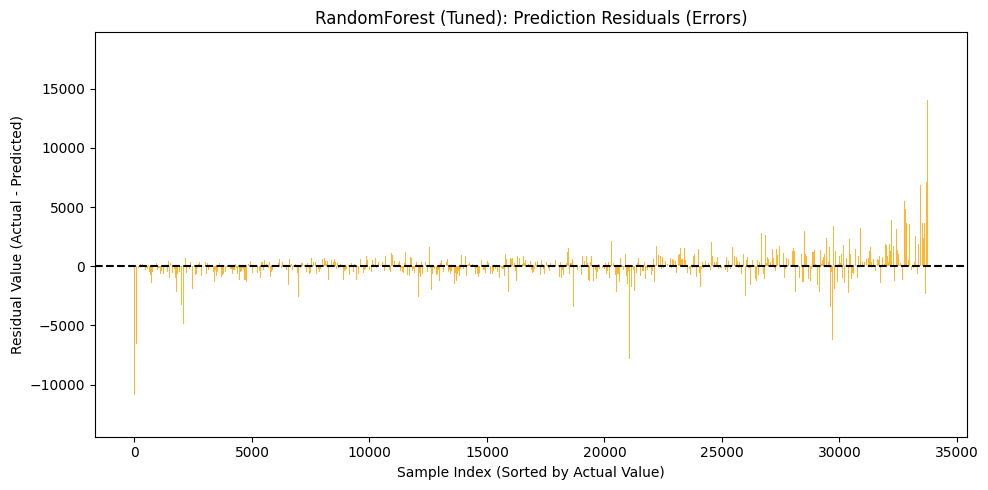


 CatBoost (Tuned) — Actual vs Predicted


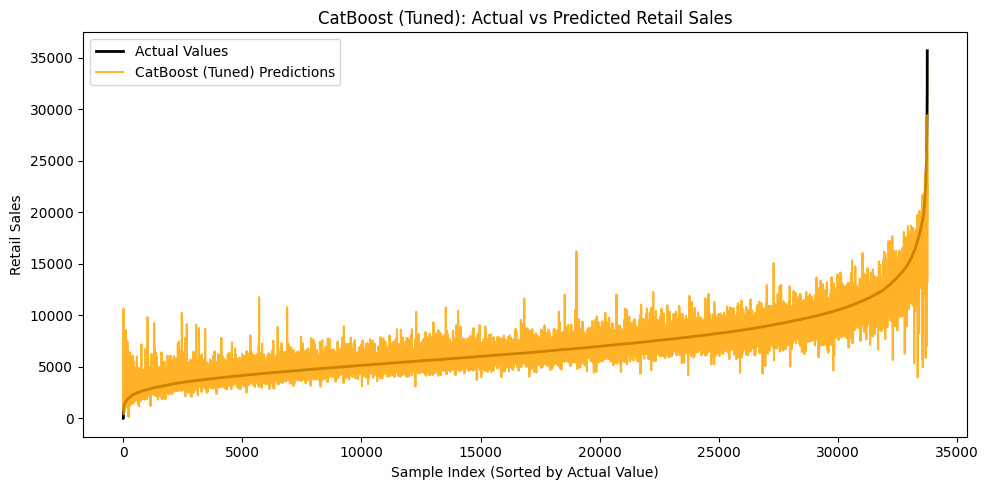

 CatBoost (Tuned) — Residuals


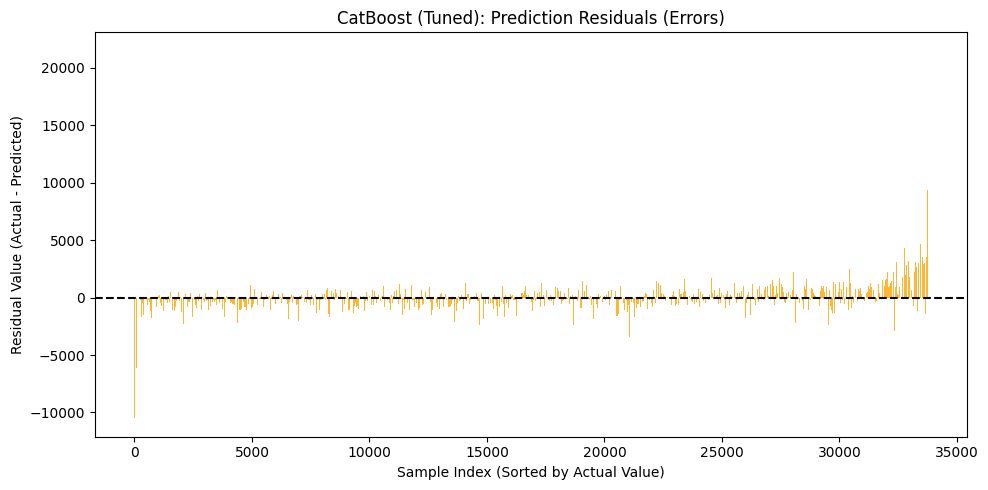

In [41]:
# ------------------------------------------------
# TUNED MODELS
# ------------------------------------------------
tuned_models = {
    "RandomForest (Tuned)": best_rf,
    "CatBoost (Tuned)": best_cat
}

for name, model in tuned_models.items():
    print(f"\n {name} — Actual vs Predicted")
    y_pred = model.predict(X_test_scaled)
    plot_sorted_actual_vs_predicted(y_test, y_pred, name, color_pred="orange")

    print(f" {name} — Residuals")
    plot_sorted_residuals(y_test, y_pred, name, color="orange")


 Weighted Ensemble — Actual vs Predicted


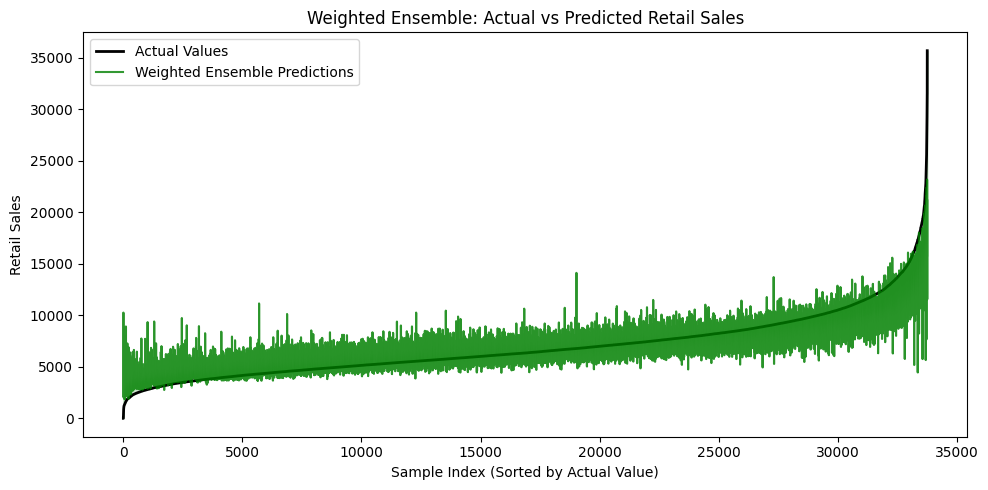

 Weighted Ensemble — Residuals


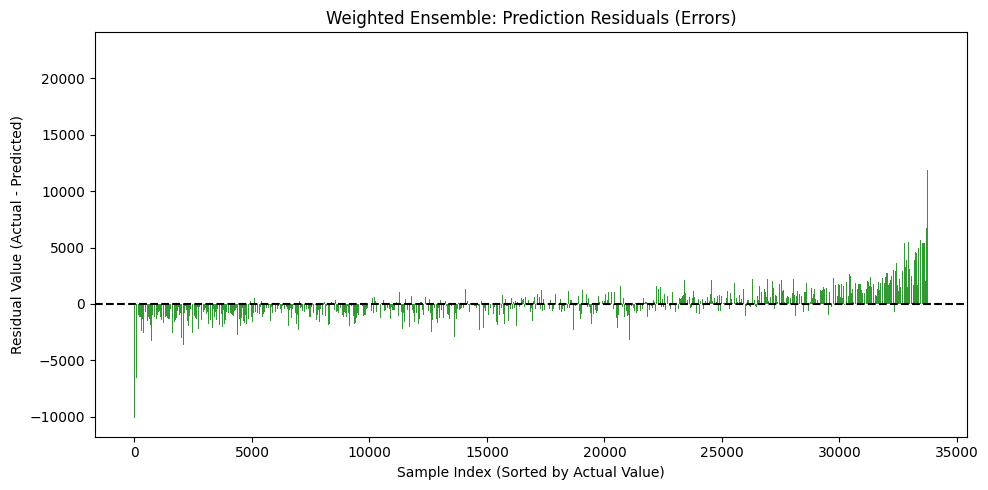


 Stacked Ensemble — Actual vs Predicted


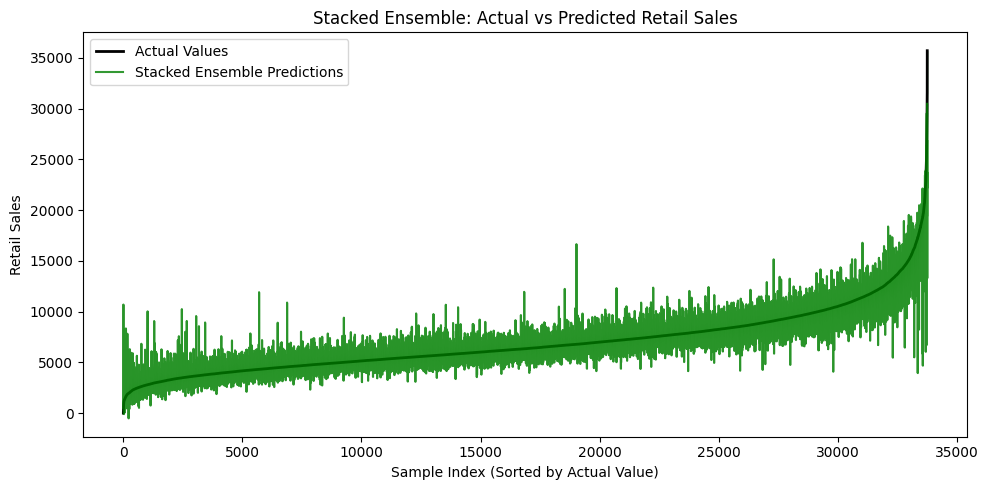

 Stacked Ensemble — Residuals


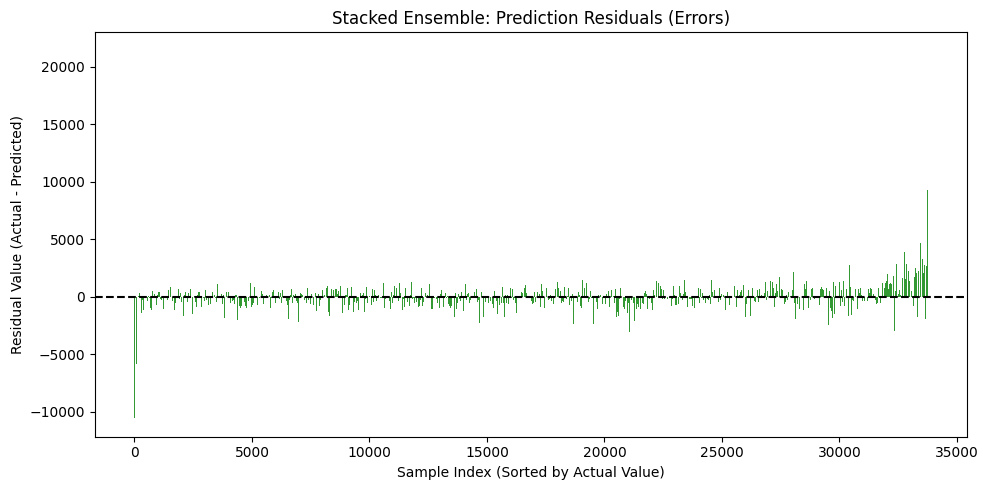

In [42]:
# ------------------------------------------------
# ENSEMBLE MODELS
# ------------------------------------------------
ensemble_predictions = {
    "Weighted Ensemble": pred_weighted,
    "Stacked Ensemble": pred_stack
}

for name, preds in ensemble_predictions.items():
    print(f"\n {name} — Actual vs Predicted")
    plot_sorted_actual_vs_predicted(y_test, preds, name, color_pred="green")

    print(f" {name} — Residuals")
    plot_sorted_residuals(y_test, preds, name, color="green")


 XGBoost (Base) — Outlier Analysis

 XGBoost (Base): Found 13 outliers (0.04% of all data points)


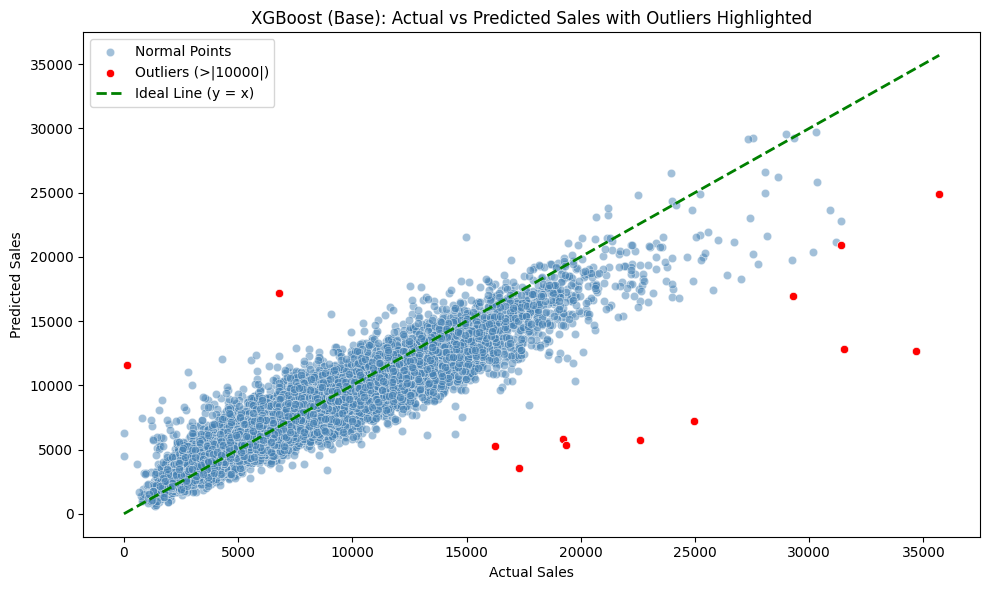


 CatBoost (Base) — Outlier Analysis

 CatBoost (Base): Found 13 outliers (0.04% of all data points)


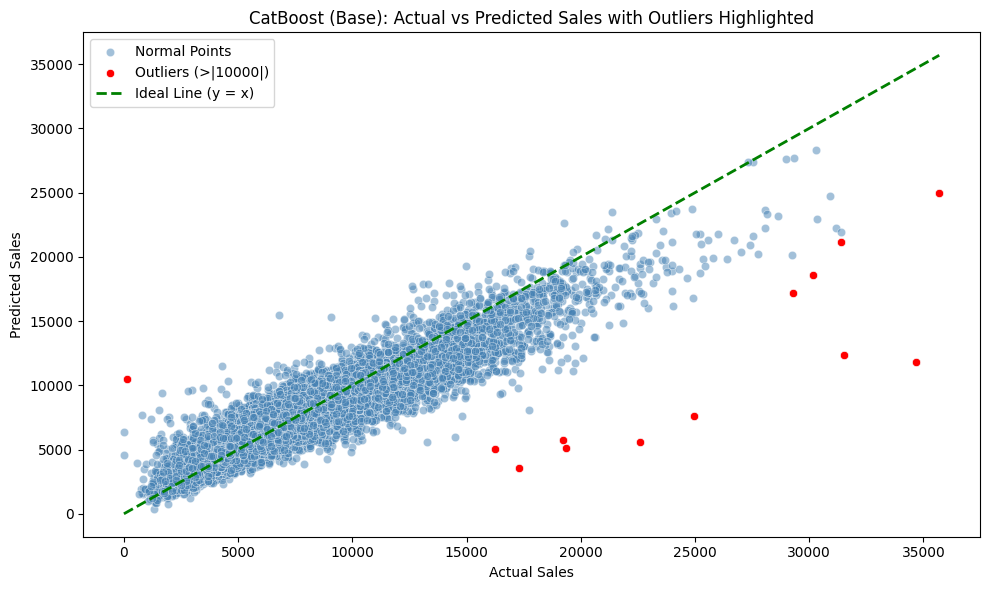


 RandomForest (Base) — Outlier Analysis

 RandomForest (Base): Found 23 outliers (0.07% of all data points)


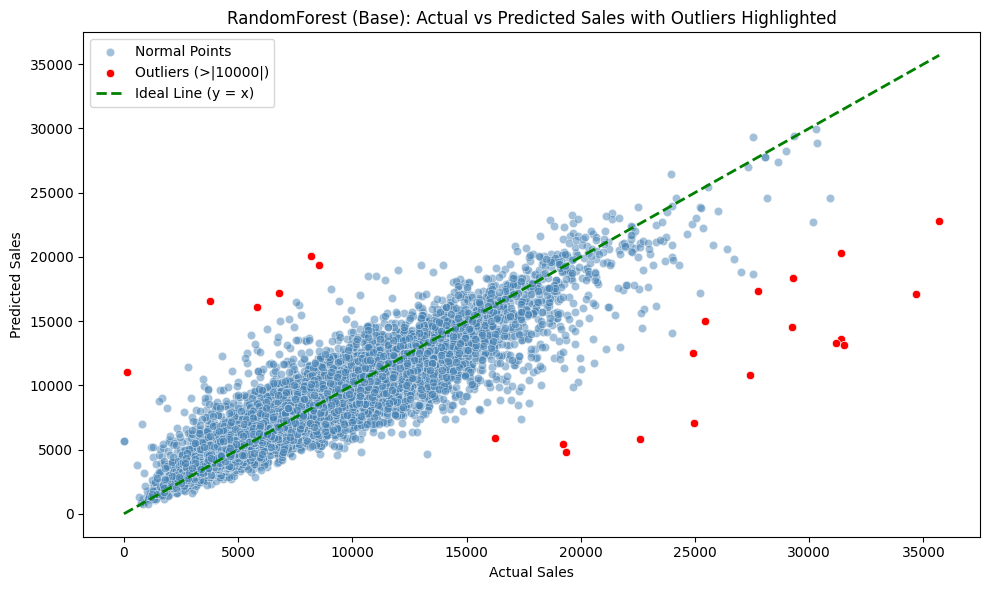

In [43]:
# ================================================================
# ACTUAL vs PREDICTED SALES with OUTLIERS HIGHLIGHTED
# ================================================================

def plot_actual_vs_predicted_outliers(y_true, y_pred, model_name, threshold=10000):
    """
    Plot Actual vs Predicted values with highlighted outliers.
    threshold – error margin above which a point is considered an outlier.
    """
    residuals = y_true - y_pred
    abs_residuals = np.abs(residuals)

    outliers_mask = abs_residuals > threshold
    num_outliers = outliers_mask.sum()
    share_outliers = num_outliers / len(y_true) * 100

    print(f"\n {model_name}: Found {num_outliers} outliers ({share_outliers:.2f}% of all data points)")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, label="Normal Points", color="steelblue")
    sns.scatterplot(
        x=y_true[outliers_mask],
        y=y_pred[outliers_mask],
        color="red", label=f"Outliers (>|{threshold}|)"
    )
    plt.plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        color="green", linestyle="--", linewidth=2, label="Ideal Line (y = x)"
    )

    plt.title(f"{model_name}: Actual vs Predicted Sales with Outliers Highlighted", fontsize=12)
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ================================================================
# MODEL-BY-MODEL OUTLIER VISUALIZATION
# ================================================================

# ------------------------------------------------
#  BASE MODELS
# ------------------------------------------------
base_models = {
    "XGBoost (Base)": models["XGBoost"],
    "CatBoost (Base)": models["CatBoost"],
    "RandomForest (Base)": models["RandomForest"]
}

for name, model in base_models.items():
    print(f"\n {name} — Outlier Analysis")
    y_pred = model.predict(X_test_scaled)
    plot_actual_vs_predicted_outliers(y_test, y_pred, name, threshold=10000)


 RandomForest (Tuned) — Outlier Analysis

 RandomForest (Tuned): Found 24 outliers (0.07% of all data points)


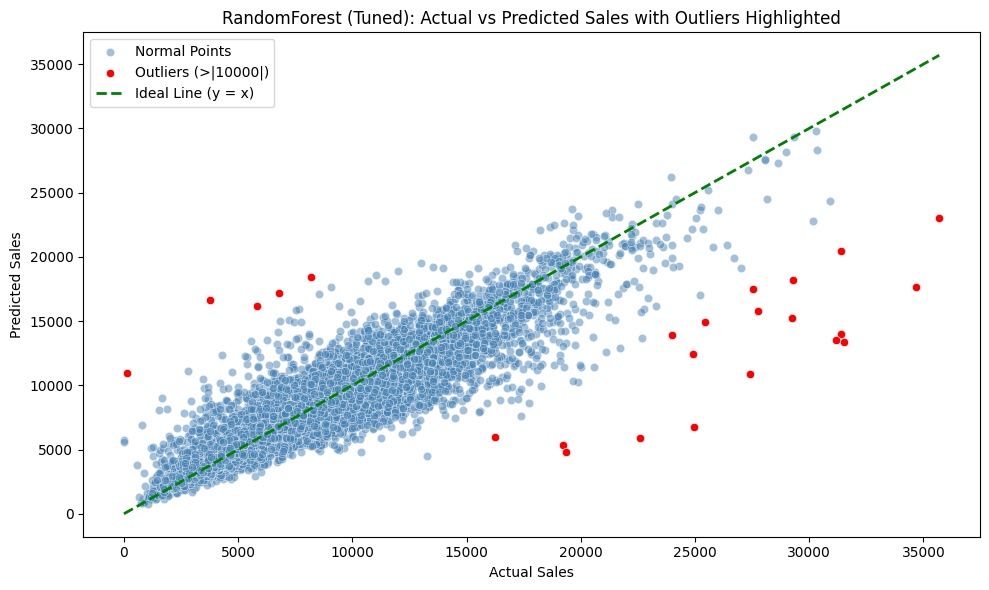


 CatBoost (Tuned) — Outlier Analysis

 CatBoost (Tuned): Found 11 outliers (0.03% of all data points)


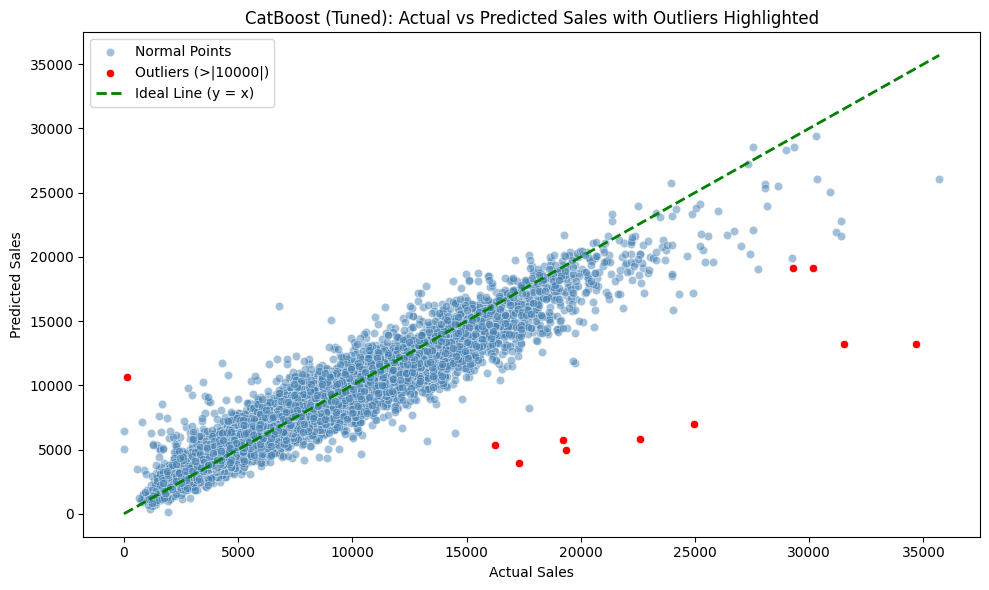

In [44]:
# ------------------------------------------------
#  TUNED MODELS
# ------------------------------------------------
tuned_models = {
    "RandomForest (Tuned)": best_rf,
    "CatBoost (Tuned)": best_cat
}

for name, model in tuned_models.items():
    print(f"\n {name} — Outlier Analysis")
    y_pred = model.predict(X_test_scaled)
    plot_actual_vs_predicted_outliers(y_test, y_pred, name, threshold=10000)


 Weighted Ensemble — Outlier Analysis

 Weighted Ensemble: Found 19 outliers (0.06% of all data points)


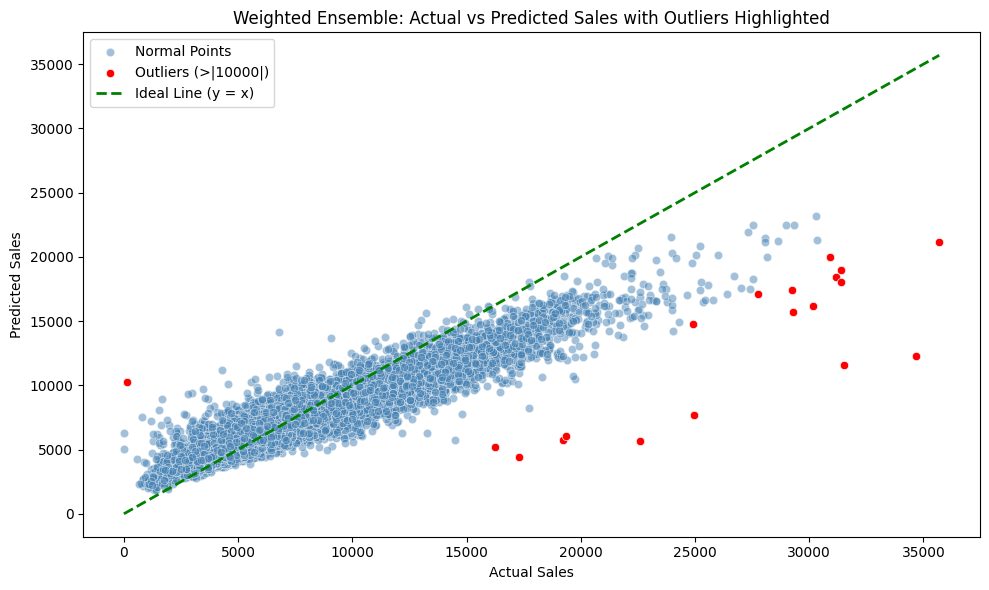


 Stacked Ensemble — Outlier Analysis

 Stacked Ensemble: Found 10 outliers (0.03% of all data points)


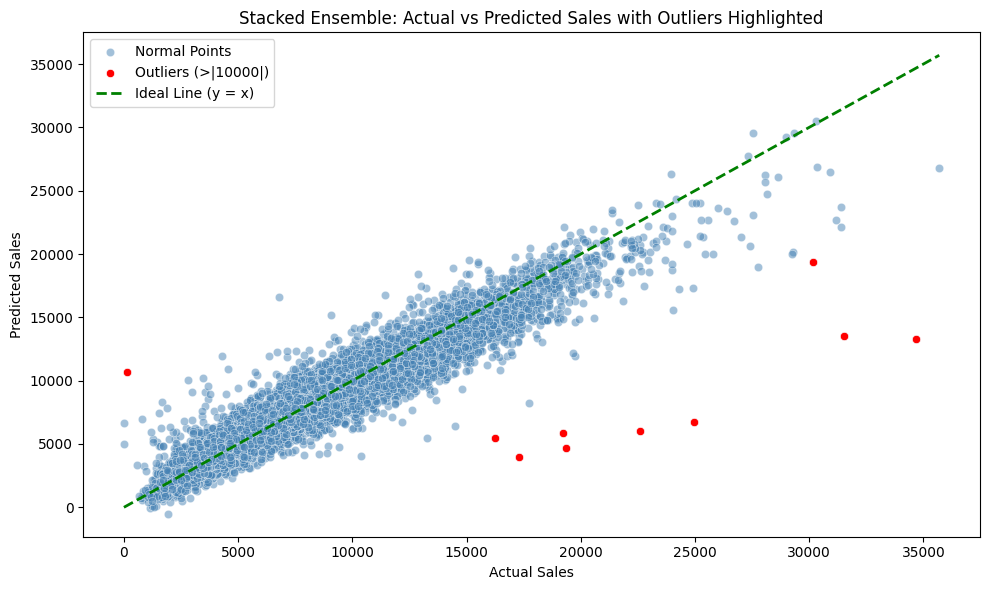

In [45]:
# ------------------------------------------------
#  ENSEMBLE MODELS
# ------------------------------------------------
ensemble_predictions = {
    "Weighted Ensemble": pred_weighted,
    "Stacked Ensemble": pred_stack
}

for name, preds in ensemble_predictions.items():
    print(f"\n {name} — Outlier Analysis")
    plot_actual_vs_predicted_outliers(y_test, preds, name, threshold=10000)

In [46]:
# ================================================================
# ACTUAL vs PREDICTED SALES with RESIDUAL HEATMAP (DISPLAY ONLY)
# ================================================================

def plot_actual_vs_predicted_with_residuals(y_true, y_pred, model_name):
    """
    Display Actual vs Predicted plot with color-coded residuals.
    """

    # Calculate residuals
    residuals = np.abs(y_true - y_pred)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Create figure and axes
    scatter = sns.scatterplot(
        x=y_true,
        y=y_pred,
        hue=residuals,
        palette="coolwarm",
        alpha=0.6,
        ax=ax # Pass the axes object to scatterplot
    )

    # Ideal line (y = x)
    ax.plot( # Use ax.plot
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        color="green",
        linestyle="--",
        linewidth=2,
        label="Ideal Line (y = x)"
    )

    # Colorbar
    norm = plt.Normalize(residuals.min(), residuals.max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax) # Pass the axes object to colorbar
    cbar.set_label("Absolute Error (|Actual - Predicted|)", rotation=270, labelpad=15)

    # Formatting
    ax.set_title(f"{model_name}: Actual vs Predicted Sales with Residual Visualization", fontsize=12) # Use ax.set_title
    ax.set_xlabel("Actual Sales") # Use ax.set_xlabel
    ax.set_ylabel("Predicted Sales") # Use ax.set_ylabel
    ax.legend() # Use ax.legend
    plt.tight_layout()
    plt.show()

    print(f" Plot displayed for: {model_name}")

Running fast SHAP on 300 samples and 16 features...

Analyzing model: CatBoost


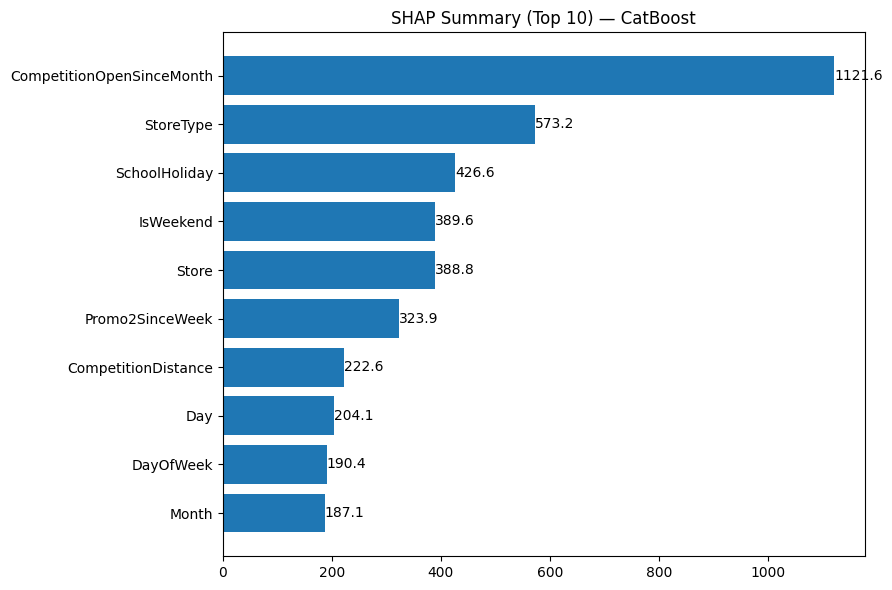

Analyzing model: RandomForest


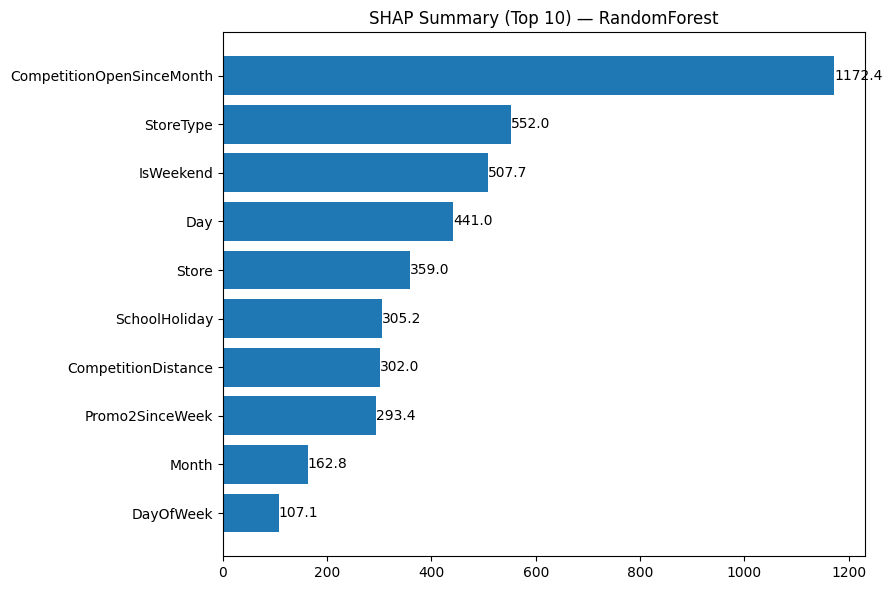

Analyzing model: LightGBM
Skipping LightGBM: module 'lightgbm' has no attribute 'predict'

Analyzing model: XGBoost


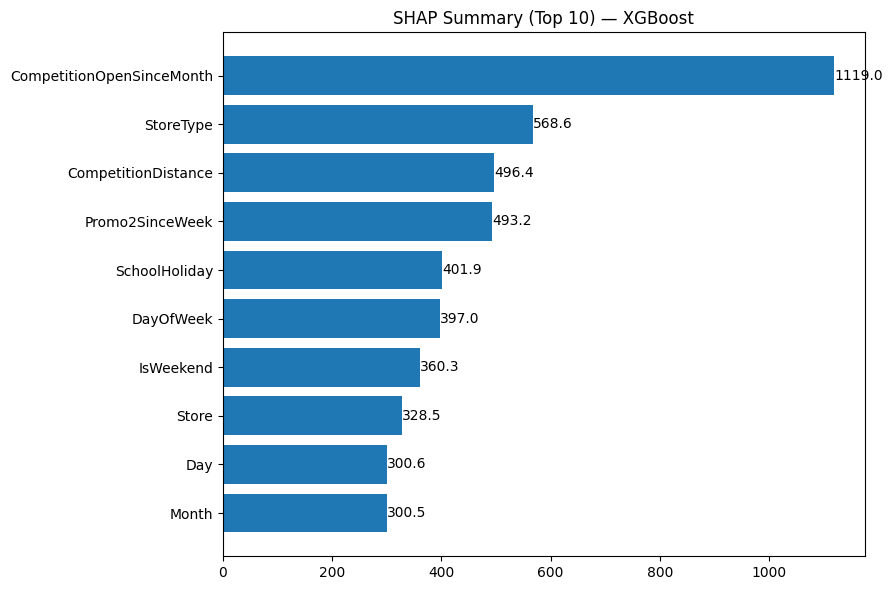

Analyzing model: ElasticNet


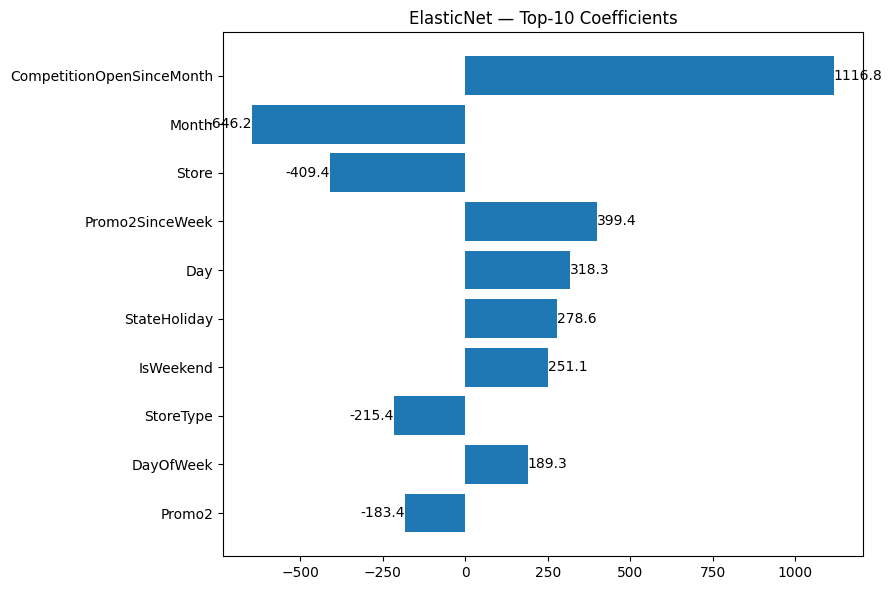


Fast SHAP analysis completed.


In [48]:
# ==============================
# SHAP Analysis — Fast Path (Optimized + Bar Labels)
# ==============================
import numpy as np
import shap
import matplotlib.pyplot as plt
from xgboost import DMatrix
import lightgbm as lgb
from catboost import Pool
import os

os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())

# ============ 1. Sampling ============
sample_size = min(300, len(X_test_scaled))
rng = np.random.default_rng(42)
sample_idx = rng.choice(len(X_test_scaled), sample_size, replace=False)

X_sample = X_test_scaled[sample_idx]
X_sample_orig = X_test.iloc[sample_idx]
y_sample = y_test.iloc[sample_idx] if 'y_test' in globals() else None

# ============ 2. Select Top Features ============
def top_features_by_importance(model, feature_names, top_n=20):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        idx = np.argsort(imp)[::-1][:min(top_n, len(imp))]
        return idx, feature_names[idx]
    return np.arange(len(feature_names)), feature_names

feature_names = np.array(X_test.columns)
keep_idx, kept_names = top_features_by_importance(
    best_cat if 'best_cat' in globals() else best_rf,
    feature_names,
    top_n=20
)

X_sample_top = X_sample[:, keep_idx]
X_sample_orig_top = X_sample_orig[kept_names]

print(f"Running fast SHAP on {sample_size} samples and {len(kept_names)} features...\n")

# ============ 3. Models ============
models_to_explain = {
    "CatBoost":      best_cat if "best_cat" in globals() else None,
    "RandomForest":  best_rf  if "best_rf"  in globals() else None,
    "LightGBM":      lgb      if "lgb"      in globals() else None,
    "XGBoost":       xgb_model if "xgb_model" in globals() else None,
    "ElasticNet":    enet     if "enet"     in globals() else None
}

explainers_cache = {}

# ============ 4. Loop ============
for name, model in models_to_explain.items():
    if model is None:
        continue

    print(f"Analyzing model: {name}")

    try:
        # ---- XGBoost ----
        if name == "XGBoost":
            dtest = DMatrix(X_sample_top, feature_names=kept_names.tolist())
            shap_values = model.get_booster().predict(dtest, pred_contribs=True)
            shap_values = shap_values[:, :-1]

        # ---- LightGBM ----
        elif name == "LightGBM":
            shap_values = model.predict(X_sample_top, pred_contrib=True)
            shap_values = shap_values[:, :-1]

        # ---- CatBoost ----
        elif name == "CatBoost":
            pool = Pool(
                X_sample_top,
                label=y_sample if y_sample is not None else None,
                feature_names=kept_names.tolist()
            )
            shap_full = model.get_feature_importance(
                type='ShapValues',
                data=pool,
                thread_count=os.cpu_count()
            )
            shap_values = shap_full[:, :-1]

        # ---- RandomForest ----
        elif name == "RandomForest":
            if 'RandomForest' not in explainers_cache:
                explainer = shap.TreeExplainer(
                    model,
                    feature_perturbation="tree_path_dependent",
                    model_output="raw",
                    approximate=True
                )
                explainers_cache['RandomForest'] = explainer
            else:
                explainer = explainers_cache['RandomForest']

            shap_values = explainer.shap_values(X_sample_top, check_additivity=False)
            if isinstance(shap_values, list):
                shap_values = shap_values[0]

        # ---- ElasticNet ----
        else:
            coefs = getattr(model, "coef_", None)
            if coefs is None:
                print("Skipping ElasticNet: no coefficients.\n")
                continue

            order = np.argsort(np.abs(coefs))[::-1][:10]
            names = kept_names[order]
            vals = coefs[order]

            plt.figure(figsize=(9, 6))
            plt.barh(names, vals)

            # Додати ваги (labels)
            for i, v in enumerate(vals):
                plt.text(v, i, f"{v:.1f}", va="center", ha="left" if v > 0 else "right")

            plt.title("ElasticNet — Top-10 Coefficients")
            plt.tight_layout()
            plt.gca().invert_yaxis()
            plt.show()
            continue

        # ============ 5. SHAP Summary (Manual barplot with labels) ============
        mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
        order = np.argsort(mean_abs_shap)[::-1][:10]

        names = kept_names[order]
        values = mean_abs_shap[order]

        plt.figure(figsize=(9, 6))
        plt.barh(names, values)

        # Додати ваги SHAP
        for i, v in enumerate(values):
            plt.text(v, i, f"{v:.1f}", va="center", ha="left")

        plt.title(f"SHAP Summary (Top 10) — {name}")
        plt.tight_layout()
        plt.gca().invert_yaxis()
        plt.show()

    except Exception as e:
        print(f"Skipping {name}: {e}\n")

print("\nFast SHAP analysis completed.")


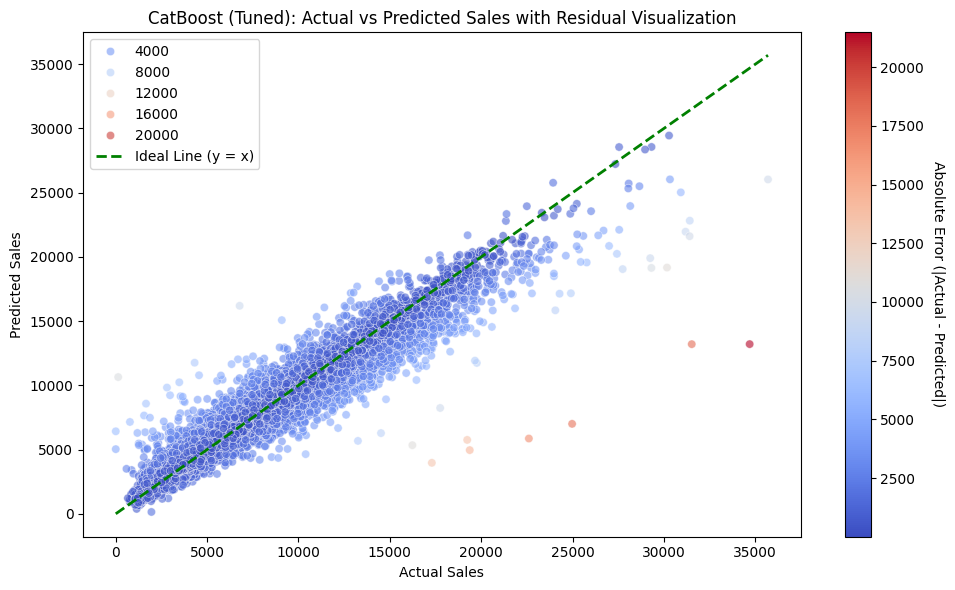

 Plot displayed for: CatBoost (Tuned)


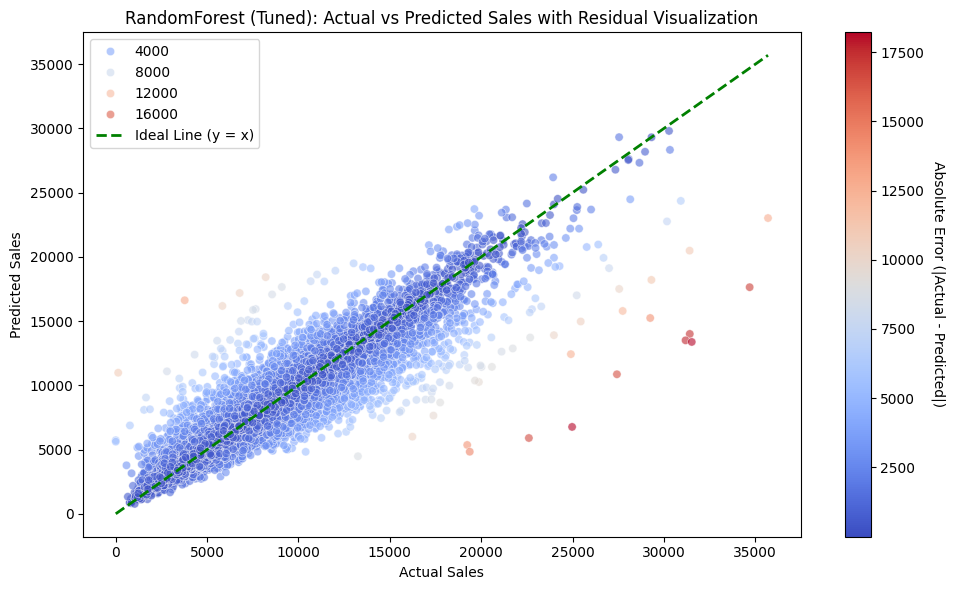

 Plot displayed for: RandomForest (Tuned)


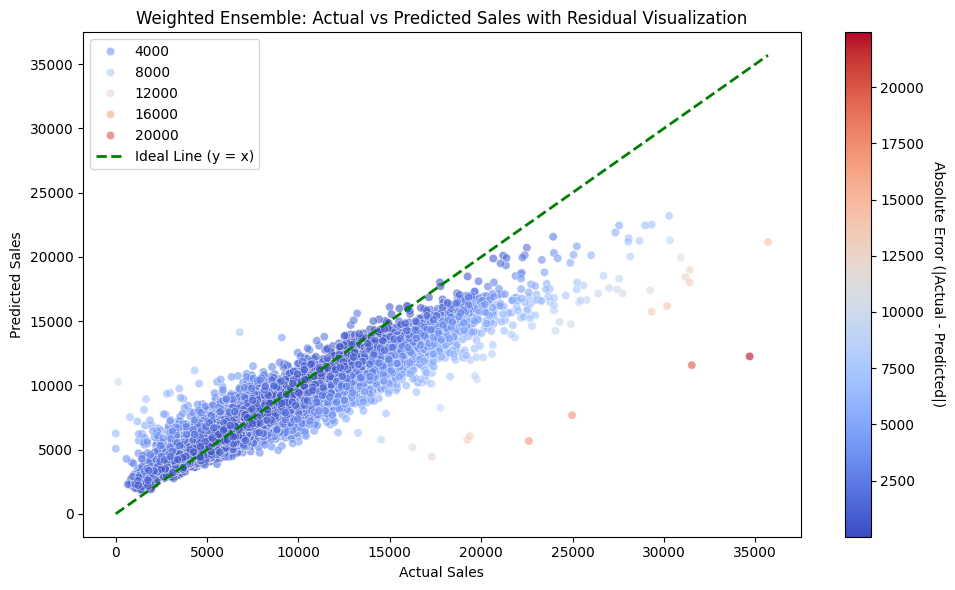

 Plot displayed for: Weighted Ensemble


In [50]:
# ================================================================
# DISPLAY RESIDUAL HEATMAPS FOR EACH MODEL
# ================================================================

# Predictions
y_pred_cat = best_cat.predict(X_test_scaled)
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_ensemble = pred_weighted

# Show plots for each model separately
plot_actual_vs_predicted_with_residuals(y_test, y_pred_cat, "CatBoost (Tuned)")
plot_actual_vs_predicted_with_residuals(y_test, y_pred_rf, "RandomForest (Tuned)")
plot_actual_vs_predicted_with_residuals(y_test, y_pred_ensemble, "Weighted Ensemble")



 Final Model Performance Summary:
                                    Model         MAE         RMSE      WAPE  \
0                                 XGBoost  823.814697  1175.530997  0.118360   
1                                CatBoost  844.724479  1202.271103  0.121365   
2                            RandomForest  724.676390  1148.989294  0.104117   
3                 Weighted Ensemble (GPU)  948.390784  1338.448899  0.136259   
4  Stacked Ensemble (GPU base + CPU meta)  642.481034   933.671130  0.092308   

        MAPE        R2  Time (s)  
0  13.419301  0.858497      0.48  
1  13.727004  0.851986      5.42  
2  11.072921  0.864814     74.76  
3  15.797928  0.816557      9.11  
4  10.356920  0.910734      9.75  


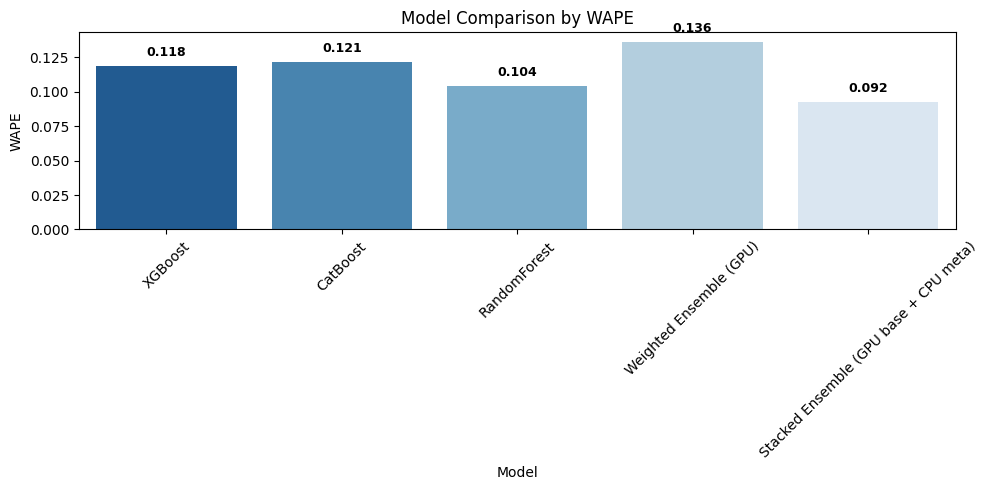

In [51]:
# ================================================================
# FINAL MODEL EVALUATION RESULTS (with MAPE + Value Labels)
# ================================================================

# Convert results list to DataFrame
results_df = pd.DataFrame(results_list)
print("\n Final Model Performance Summary:")
print(results_df[["Model", "MAE", "RMSE", "WAPE", "MAPE", "R2", "Time (s)"]])

# Helper function to add value labels on bars
def add_value_labels(ax, fmt="{:.3f}", spacing=5):
    """Add labels with values above each bar."""
    for p in ax.patches:
        ax.annotate(
            fmt.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom',
            xytext=(0, spacing), textcoords='offset points',
            fontsize=9, color='black', fontweight='bold'
        )

# ------------------------------
# Plot WAPE
# ------------------------------
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="Model", y="WAPE", data=results_df, palette="Blues_r")
plt.title("Model Comparison by WAPE")
plt.xlabel("Model")
plt.ylabel("WAPE")
plt.xticks(rotation=45)
add_value_labels(ax, fmt="{:.3f}")
plt.tight_layout()
plt.show()




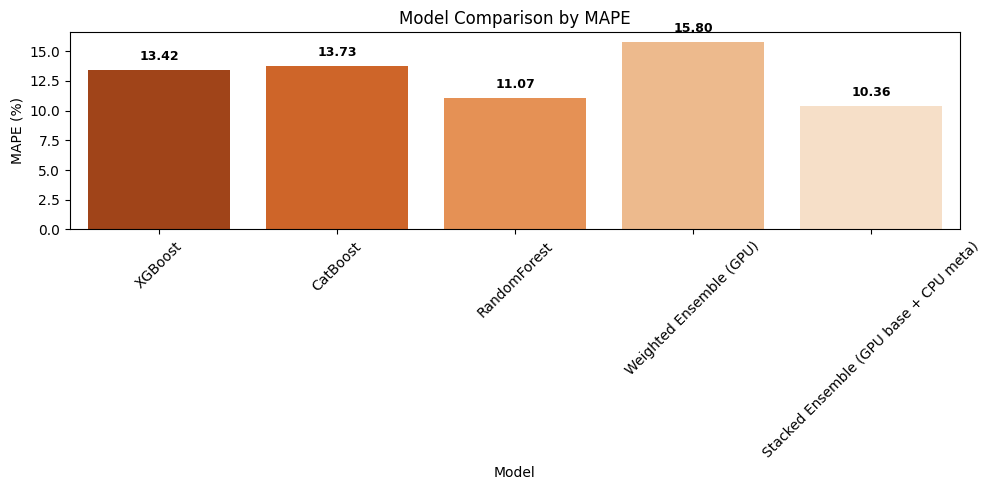

In [52]:
# ------------------------------
# Plot MAPE
# ------------------------------
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="Model", y="MAPE", data=results_df, palette="Oranges_r")
plt.title("Model Comparison by MAPE")
plt.xlabel("Model")
plt.ylabel("MAPE (%)")
plt.xticks(rotation=45)
add_value_labels(ax, fmt="{:.2f}")
plt.tight_layout()
plt.show()

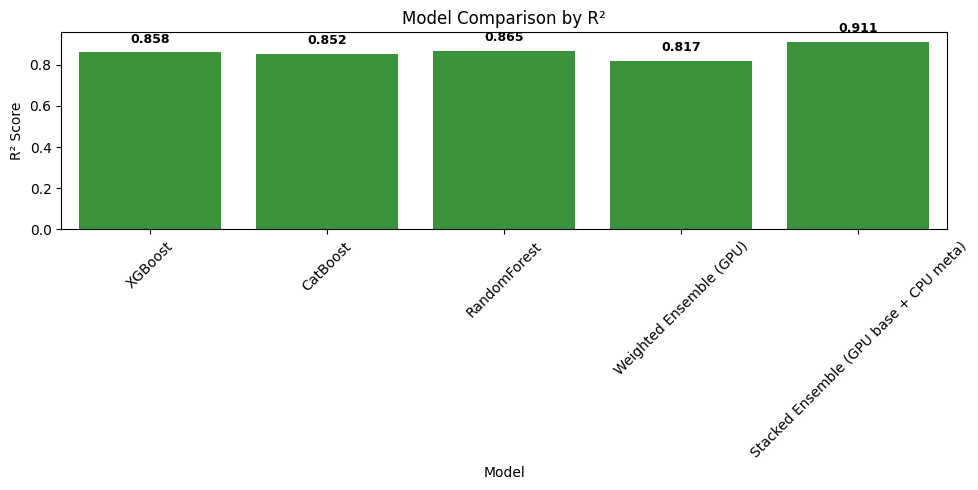

In [53]:
# ------------------------------
# Plot R²
# ------------------------------
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="Model", y="R2", data=results_df, color="#2ca02c")
plt.title("Model Comparison by R²")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
add_value_labels(ax, fmt="{:.3f}")
plt.tight_layout()
plt.show()

In [54]:
# ------------------------------
# Print summary
# ------------------------------
best_wape_model = results_df.loc[results_df["WAPE"].idxmin(), "Model"]
best_mape_model = results_df.loc[results_df["MAPE"].idxmin(), "Model"]
best_r2_model = results_df.loc[results_df["R2"].idxmax(), "Model"]

print(f"\n Best model by WAPE: {best_wape_model}")
print(f" Best model by MAPE: {best_mape_model}")
print(f" Best model by R²:   {best_r2_model}")

print("\nBest RandomForest parameters:", grid_rf.best_params_)
print("Best CatBoost parameters:", best_params_cat)


 Best model by WAPE: Stacked Ensemble (GPU base + CPU meta)
 Best model by MAPE: Stacked Ensemble (GPU base + CPU meta)
 Best model by R²:   Stacked Ensemble (GPU base + CPU meta)

Best RandomForest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400}
Best CatBoost parameters: {'depth': 10, 'learning_rate': 0.1443263011149883, 'iterations': 461, 'l2_leaf_reg': 8.324442140638345}


In [55]:
# ================================================================
# MODEL COMPARISON TABLE (with MAPE)
# ================================================================

# Round numeric columns
comparison_df = results_df.copy()
numeric_cols = ["MAE", "RMSE", "R2", "WAPE", "MAPE", "Time (s)"]
comparison_df[numeric_cols] = comparison_df[numeric_cols].applymap(
    lambda x: round(x, 4) if isinstance(x, (int, float)) else x
)

# Identify best models
best_wape_idx = comparison_df["WAPE"].idxmin()
best_mape_idx = comparison_df["MAPE"].idxmin()
best_r2_idx = comparison_df["R2"].idxmax()

# Sort by WAPE (lower = better)
comparison_df = comparison_df.sort_values(by="WAPE", ascending=True).reset_index(drop=True)

# Display formatted table
print(" Model comparison by key metrics:")
display(
    comparison_df.style
    .highlight_min(subset=["MAE", "RMSE", "WAPE", "MAPE"], color="#b9fbc0")  # green = best (lower)
    .highlight_max(subset=["R2"], color="#a0c4ff")  # blue = best (higher)
    .set_table_styles([
        {"selector": "th",
         "props": [("background-color", "#f0f0f0"), ("font-weight", "bold")]}
    ])
)

# Summary
print(f"\n Best model by WAPE: {comparison_df.loc[best_wape_idx, 'Model']}")
print(f" Best model by MAPE: {comparison_df.loc[best_mape_idx, 'Model']}")
print(f" Best model by R²:   {comparison_df.loc[best_r2_idx, 'Model']}")


 Model comparison by key metrics:



 Best model by WAPE: Weighted Ensemble (GPU)
 Best model by MAPE: Weighted Ensemble (GPU)
 Best model by R²:   Weighted Ensemble (GPU)
